Milestone 1 Phase 2<br>
Nama : Risqi Wahyu Permana<br>
Batch: HCK 6

# Introduction

**Background:** A company wants to minimize the risk of a customer to stop using the product they offer. 

**Assumption:** The products they offer are digital products such as in-game items, subscription to an application and others. 

**Problem:** We are told to help the company to predict customers who will quit (churn) from the given dataset.

**Questions**

1. What ages are using our products?
2. How many members in each category?
3. Which category of members quit the most?
4. What are the complaints and amounts given by customers?
5. Looking at the comparison of how many customers quit in terms of discount usage?

---
Dataset Description
---
Dataset name : `churn.csv`

| Column | Description |
| --- | --- |
| `user_id` | ID of a customer |
| `age` | Age of a customer |
| `gender` | Gender of a customer |
| `region_category` | Region that a customer belongs to |
| `membership_category` | Category of the membership that a customer is using |
| `joining_date` | Date when a customer became a member |
| `joined_through referral` | Whether a customer joined using any referral code or ID |
| `preferred_offer types` | Type of offer that a customer prefers |
| `medium_of operation` | Medium of operation that a customer uses for transactions |
| `internet_option` | Type of internet service a customer uses |
| `last_visit_time` | The last time a customer visited the website |
| `days_since_last_login` | Number of days since a customer last logged into the website |
| `avg_time_spent` | Average time spent by a customer on the website |
| `avg_transaction_value` | Average transaction value of a customer |
| `avg_frequency_login_days` | Number of times a customer has logged in to the website |
| `points_in_wallet` | Points awarded to a customer on each transaction |
| `used_special_discount` | Whether a customer uses special discounts offered |
| `offer_application_preference` | Whether a customer prefers offers |
| `past_complaint` | Whether a customer has raised any complaints |
| `complaint_status` | Whether the complaints raised by a customer was resolved |
| `feedback` | Feedback provided by a customer |
| `churn_risk_score` | Churn score <br><br> `0` : Not churn <br> `1` : Churn |

# Import Libraries

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from feature_engine.outliers import Winsorizer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import joblib
np.random.seed(50)
tf.random.set_seed(50)

# Function

In [2]:
def normal(df,col):
    upper = df[col].mean() + (3 * df[col].std())
    lower = df[col].mean() - (3 * df[col].std())

    outlier = df[(df[col] <= lower) | (df[col] >= upper)]

    print('percentage: ', len(outlier)/df.shape[0] * 100, '%')

def skew(df, col, fold):
    Q1 = df[col].quantile(.25)
    Q3 = df[col].quantile(.75)

    IQR = Q3 - Q1

    upper = Q3 + (fold*IQR)
    lower = Q1 - (fold*IQR)

    outlier = df[(df[col] <= lower) | (df[col] >= upper)]

    print('percentage: ', len(outlier)/df.shape[0] * 100, '%')
    print('upper: ', upper)
    print('lower: ', lower)

In [3]:
#Function to plot distribution
def plot_dist(df, col):
    fig, axes = plt.subplots(ncols = 2, figsize = (15, 5))
    
    # histogram
    sns.histplot(df[col],ax = axes[0], bins=30)
    axes[0].set_title(f"Histogram '{col}'")
    axes[0].axvline(df[col].mean(), color = 'red', linestyle = 'dashed', label = 'mean')
    axes[0].axvline(df[col].median(), color = 'green', linestyle = 'dashed', label = 'median')
    axes[0].legend()
    
    # boxplot
    sns.boxplot(y=df[col], ax =  axes[1])
    axes[1].set_title(f"Boxplot '{col}'")
    
    plt.show()
    
    # skewness
    print(df[col].name + ' Kurtosis: ' + str(df[col].kurt()))
    print(df[col].name + ' Skewness: ' + str(df[col].skew()))
    if -0.5 <= df[col].skew() <= 0.5:
        print("Columns '{}' normal distribution".format(col))
        normal(df, col)
    elif df[col].skew() > 0.5:
        if df[col].skew() > 1:
            print("Columns '{}' extreme right skewed".format(col))
            skew(df, col, 3)
        else:
            print("Columns '{}' right skewed".format(col))
            skew(df, col, 1.5)
    elif df[col].skew() < -0.5:
        if df[col].skew() < 1:
            print("Columns '{}' extreme left skewed".format(col))
            skew(df, col, 3)
        else:
            print("Columns '{}' left skewed".format(col))
            skew(df, col, 1.5)

# EDA

## EDA for Analysis

Data Loading

In [4]:
#no limit display
pd.set_option('display.max_columns', None)
df = pd.read_csv('churn.csv')
df.head()

,user_id,age,gender,region_category,membership_category,joining_date,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,9f420209e7d129f3,29,F,NaN,No Membership,2017-04-05,Yes,Without Offers,NaN,Wi-Fi,22:29:49,4,1184.49,38604.69,10.0,627.48,Yes,Yes,Yes,No Information Available,Poor Website,1
1,ac6e97806267549e,50,M,NaN,Basic Membership,2017-03-31,Yes,Without Offers,Desktop,Fiber_Optic,15:44:56,11,338.15,7665.66,17.0,575.97,Yes,No,Yes,No Information Available,Poor Customer Service,1
2,a6aa19b1580eed4e,26,F,City,Silver Membership,2017-02-11,NaN,Credit/Debit Card Offers,NaN,Fiber_Optic,20:31:53,8,235.14,37671.69,5.0,767.93,Yes,No,Yes,No Information Available,Too many ads,0
3,aeee343277211c2f,63,F,Village,No Membership,2015-12-23,No,Credit/Debit Card Offers,Desktop,Fiber_Optic,14:28:05,10,56.67,15678.14,11.0,590.22,No,Yes,No,Not Applicable,Too many ads,1
4,82448b5c8ce6390c,64,M,Town,Silver Membership,2015-03-20,NaN,Gift Vouchers/Coupons,Smartphone,Wi-Fi,04:16:48,9,153.99,8422.68,0.0,722.04,Yes,No,No,Not Applicable,Poor Product Quality,0


Drop user_id because we don't need it.

In [5]:
#drop user_id
df.drop(columns=['user_id'], inplace=True)

Check each column's data type, correct if there are any that do not match the data type.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37010 entries, 0 to 37009
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           37010 non-null  int64  
 1   gender                        36951 non-null  object 
 2   region_category               31579 non-null  object 
 3   membership_category           37010 non-null  object 
 4   joining_date                  37010 non-null  object 
 5   joined_through_referral       31568 non-null  object 
 6   preferred_offer_types         36722 non-null  object 
 7   medium_of_operation           31615 non-null  object 
 8   internet_option               37010 non-null  object 
 9   last_visit_time               37010 non-null  object 
 10  days_since_last_login         37010 non-null  int64  
 11  avg_time_spent                37010 non-null  float64
 12  avg_transaction_value         37010 non-null  float64
 13  a

In [7]:
#convert joining date to datetime
df['joining_date'] = pd.to_datetime(df['joining_date'])

#convert last_visit_time to time
df['last_visit_time'] = pd.to_datetime(df['last_visit_time'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37010 entries, 0 to 37009
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   age                           37010 non-null  int64         
 1   gender                        36951 non-null  object        
 2   region_category               31579 non-null  object        
 3   membership_category           37010 non-null  object        
 4   joining_date                  37010 non-null  datetime64[ns]
 5   joined_through_referral       31568 non-null  object        
 6   preferred_offer_types         36722 non-null  object        
 7   medium_of_operation           31615 non-null  object        
 8   internet_option               37010 non-null  object        
 9   last_visit_time               37010 non-null  datetime64[ns]
 10  days_since_last_login         37010 non-null  int64         
 11  avg_time_spent              

Check null value.

In [9]:
df.isnull().sum()

age                                0
gender                            59
region_category                 5431
membership_category                0
joining_date                       0
joined_through_referral         5442
preferred_offer_types            288
medium_of_operation             5395
internet_option                    0
last_visit_time                    0
days_since_last_login              0
avg_time_spent                     0
avg_transaction_value              0
avg_frequency_login_days           0
points_in_wallet                   0
used_special_discount              0
offer_application_preference       0
past_complaint                     0
complaint_status                   0
feedback                           0
churn_risk_score                   0
dtype: int64

There are 5 columns with null values. we will handle them in data preprocessing.

Check duplicate data.

In [10]:
df.duplicated().sum()

18

There are 5 duplicate data. we will handle them in data preprocessing.

Now we look at the unique values in each column. This is to determine if there is any anomalous data.

In [11]:
for column in df.columns:
    value_counts = df[column].value_counts()
    print(f"Value counts for column'{column}':\n{value_counts}\n")

Value counts for column'age':
33    720
42    716
16    716
38    714
30    711
61    710
57    704
60    704
41    699
59    697
55    696
28    694
34    692
47    692
21    689
32    685
17    684
56    683
29    682
45    680
48    680
46    679
58    679
22    677
62    677
26    676
53    675
64    672
52    672
14    670
10    670
23    669
36    669
49    669
44    662
12    661
51    660
19    660
27    659
35    658
43    657
63    656
50    656
11    654
13    654
37    653
15    649
24    645
39    644
20    641
31    636
25    635
18    630
40    628
54    610
Name: age, dtype: int64

Value counts for column'gender':
F    18497
M    18454
Name: gender, dtype: int64

Value counts for column'region_category':
Town       14135
City       12744
Village     4700
Name: region_category, dtype: int64

Value counts for column'membership_category':
Basic Membership       7727
No Membership          7693
Gold Membership        6799
Silver Membership      5991
Premium Membership     4

In [12]:
df.describe()

,age,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,churn_risk_score
count,37010.000000,37010.000000,37010.000000,37010.000000,37010.000000,37010.000000,37010.000000
mean,37.120697,-41.943502,279.201356,29272.430216,14.659540,623.590885,0.540881
std,15.866834,228.875324,330.017336,19445.963492,9.478756,270.218956,0.498333
min,10.000000,-999.000000,0.000000,800.460000,0.000000,0.000000,0.000000
25%,23.000000,8.000000,60.122500,14177.835000,7.000000,574.220000,0.000000
50%,37.000000,12.000000,161.770000,27554.485000,14.000000,680.400000,1.000000
75%,51.000000,16.000000,356.525000,40858.672500,22.000000,756.990000,1.000000
max,64.000000,26.000000,3235.578521,99914.050000,73.061995,2069.069761,1.000000


It turns out that there is an anomaly data where the days_since_last_login column has a value of -999 which is impossible. We will handle it in data preprocessing.

In [13]:
#see chrun risk distribution
df['churn_risk_score'].value_counts()

1    20018
0    16992
Name: churn_risk_score, dtype: int64

check whether the dataset is balanced or not

<Axes: >

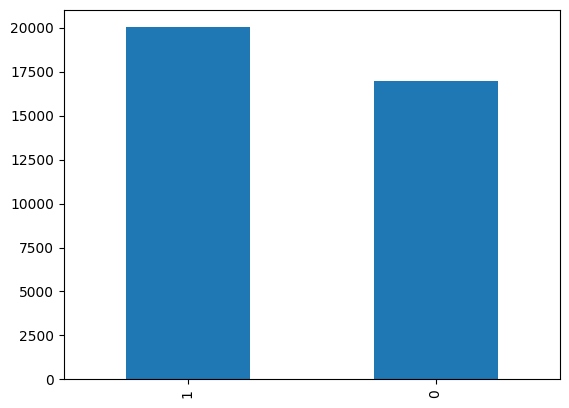

In [14]:
df['churn_risk_score'].value_counts().plot(kind='bar')

Perform under sampling to balance the data.

In [15]:
df_0 = df[df['churn_risk_score'] == 0]
df_1 = df[df['churn_risk_score'] == 1]
df_1 = df_1.sample(len(df_0))
df = pd.concat([df_0, df_1])
df= df.sample(len(df)).reset_index(drop=True)
df

,age,gender,region_category,membership_category,joining_date,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,38,F,City,Basic Membership,2017-11-09,No,Credit/Debit Card Offers,NaN,Fiber_Optic,2023-07-28 19:52:02,14,127.84,30538.73,29.00000,508.800000,No,Yes,No,Not Applicable,No reason specified,1
1,52,F,Town,Basic Membership,2016-08-24,No,Gift Vouchers/Coupons,Smartphone,Wi-Fi,2023-07-28 05:10:18,3,166.57,45964.80,17.00000,630.000000,Yes,No,Yes,No Information Available,Too many ads,1
2,49,M,Town,Premium Membership,2017-07-22,Yes,Gift Vouchers/Coupons,Both,Wi-Fi,2023-07-28 02:04:51,4,554.91,38160.19,21.00000,750.030000,Yes,Yes,No,Not Applicable,No reason specified,0
3,36,F,NaN,Silver Membership,2015-12-23,Yes,Without Offers,Smartphone,Wi-Fi,2023-07-28 19:10:06,9,32.33,6598.65,8.00000,0.000000,No,Yes,Yes,Solved in Follow-up,Poor Website,1
4,59,M,City,Silver Membership,2015-01-26,No,Credit/Debit Card Offers,Both,Wi-Fi,2023-07-28 12:56:29,13,255.79,48734.29,0.00000,0.000000,Yes,No,No,Not Applicable,Poor Customer Service,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33979,32,F,City,No Membership,2015-11-19,No,Gift Vouchers/Coupons,Desktop,Mobile_Data,2023-07-28 01:58:54,4,117.27,11754.17,21.00000,352.773679,Yes,No,Yes,Unsolved,Poor Customer Service,1
33980,36,F,City,Gold Membership,2015-06-22,No,Gift Vouchers/Coupons,Smartphone,Mobile_Data,2023-07-28 22:10:13,16,327.92,18366.03,19.00000,720.850000,No,Yes,Yes,Solved,Poor Customer Service,0
33981,24,M,Town,Premium Membership,2016-03-06,Yes,Gift Vouchers/Coupons,NaN,Fiber_Optic,2023-07-28 03:54:15,4,621.65,67622.52,18.00000,1042.111752,No,Yes,Yes,No Information Available,Reasonable Price,0
33982,50,M,City,Gold Membership,2016-09-04,Yes,Gift Vouchers/Coupons,Desktop,Mobile_Data,2023-07-28 19:07:07,-999,144.06,38951.81,5.00000,730.710000,Yes,No,No,Not Applicable,Poor Customer Service,0


<Axes: >

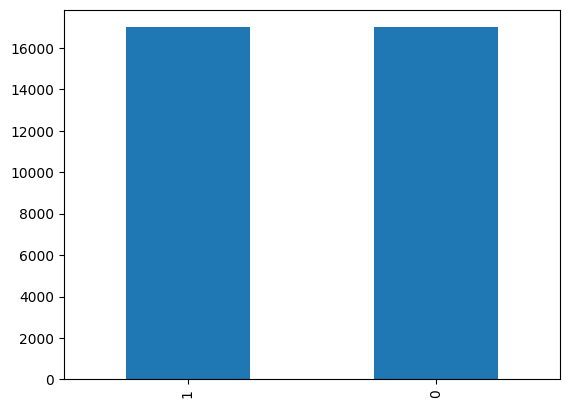

In [16]:
df['churn_risk_score'].value_counts().plot(kind='bar')

## EDA for Business

1. What ages are using our products?

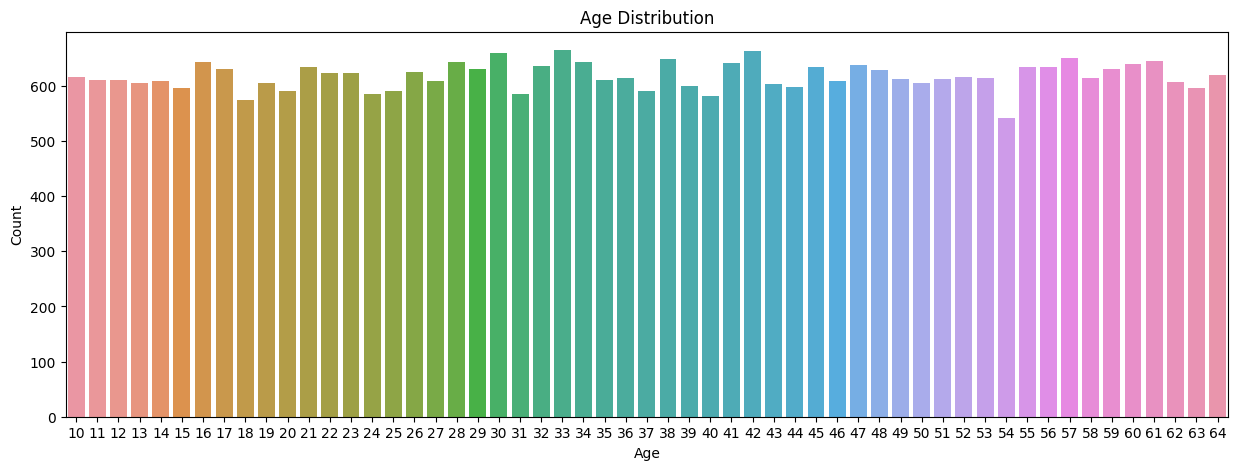

In [17]:
#see age distribution use barplot
plt.figure(figsize=(15,5))
sns.barplot(x=df['age'].value_counts().index, y=df['age'].value_counts().values)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution')
plt.show()

It turns out that the age of product users is in the age range of 10 years to 64 years and has a uniform distribution.

2. How many members in each category?

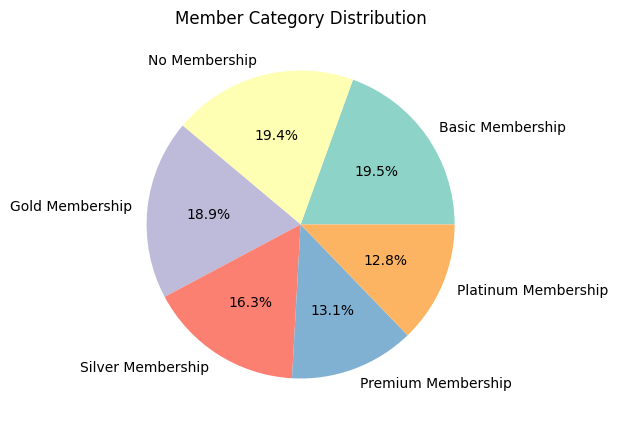

In [18]:
#Use Piechart to see member category distribution use piechart seaborn
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
ax.pie(df['membership_category'].value_counts().values, labels=df['membership_category'].value_counts().index, autopct='%1.1f%%', colors=sns.color_palette('Set3'))
ax.set_title('Member Category Distribution')
plt.show()

Basic membership, no membership, gold membership are the top 3 membership categories.

3. Which category of members quit the most?

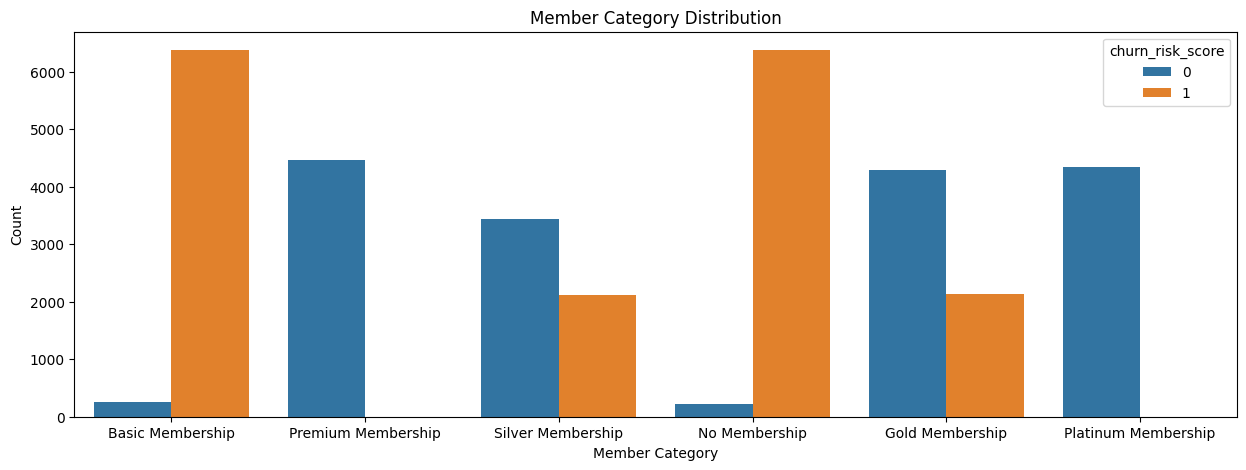

In [108]:
#see Which category of members quit the most?
plt.figure(figsize=(15,5))
sns.countplot(x=df['membership_category'], hue=df['churn_risk_score'])
plt.xlabel('Member Category')
plt.ylabel('Count')
plt.title('Member Category Distribution')
plt.show()

The customers who leave the most are those who do not have a membership and those who have a basic membership.

4. What are the complaints and amounts given by customers?

In [20]:
#make df to see complaint status and count it
df_complaint = pd.DataFrame(df['complaint_status'].value_counts())
df_complaint.reset_index(inplace=True)
df_complaint.columns = ['complaint_status', 'count']
df_complaint

,complaint_status,count
0,Not Applicable,17078
1,Unsolved,4286
2,Solved,4260
3,Solved in Follow-up,4204
4,No Information Available,4156


After we get the complaint status information. We see from the complaint status, which one makes the most customers leave?

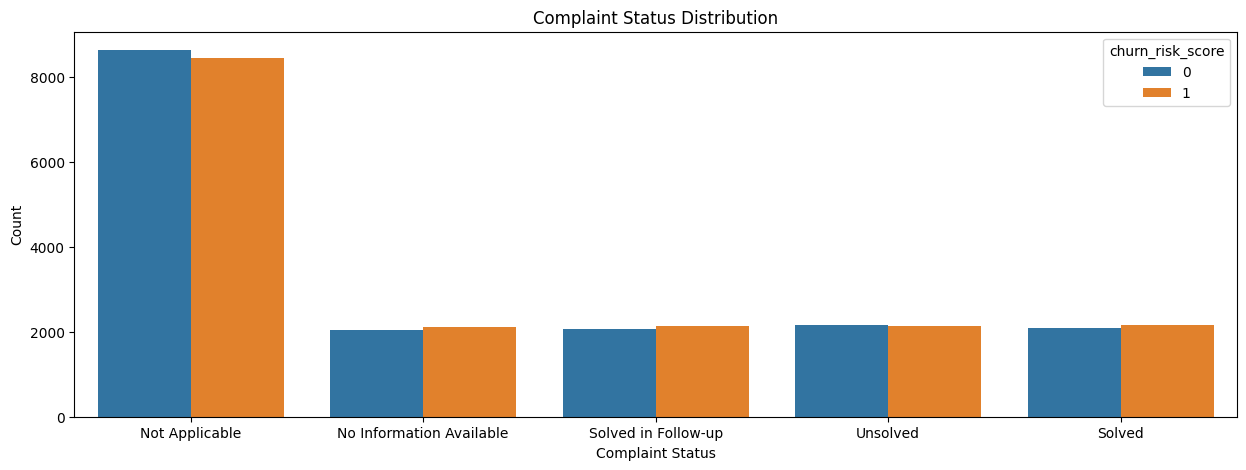

In [21]:
#What are the complaints and amounts given by customers?
plt.figure(figsize=(15,5))
sns.countplot(x=df['complaint_status'], hue=df['churn_risk_score'])
plt.xlabel('Complaint Status')
plt.ylabel('Count')
plt.title('Complaint Status Distribution')
plt.show()

From here the above plot can be seen, the customers who leave and stay are actually balanced. However, we get information that there are still many complaints that are not applicable.

5. Looking at the comparison of how many customers quit in terms of discount usage?

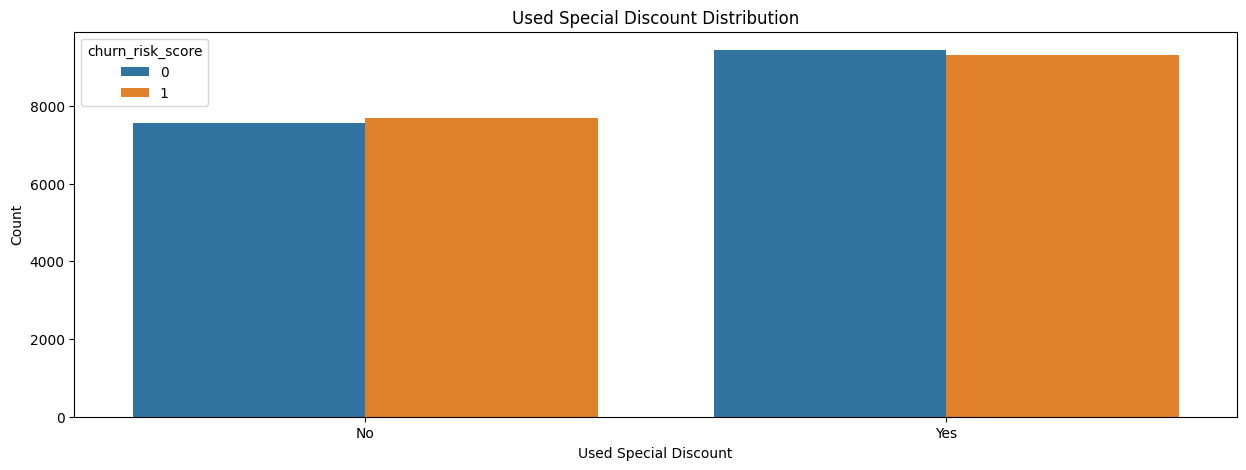

In [22]:
#Looking at the comparison of how many customers quit in terms of discount usage?
plt.figure(figsize=(15,5))
sns.countplot(x=df['used_special_discount'], hue=df['churn_risk_score'])
plt.xlabel('Used Special Discount')
plt.ylabel('Count')
plt.title('Used Special Discount Distribution')
plt.show()

There is no difference between those with exit and fixed risks based on the use of discounts.

# Data Preprocessing (Feature Engineering)

What are we going to handle in terms of eda:
- Null value.
- Duplicate data.
- Anomaly data in days_since_login column.
- Retrieve year only in date_joined column.
- Retrieve hour only in time_last_visit column.


In [23]:
df_prep = df.copy()

## Remove duplicate data

In [24]:
df_prep.drop_duplicates(inplace=True)

In [25]:
df_prep.duplicated().sum()

0

## Handle Anomaly 

Handle Anomaly in column days_since_last_login

In [26]:
#change -999 to 27
df_prep['days_since_last_login'] = df_prep['days_since_last_login'].replace(-999, 27)

In [27]:
df_prep

,age,gender,region_category,membership_category,joining_date,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,38,F,City,Basic Membership,2017-11-09,No,Credit/Debit Card Offers,NaN,Fiber_Optic,2023-07-28 19:52:02,14,127.84,30538.73,29.00000,508.800000,No,Yes,No,Not Applicable,No reason specified,1
1,52,F,Town,Basic Membership,2016-08-24,No,Gift Vouchers/Coupons,Smartphone,Wi-Fi,2023-07-28 05:10:18,3,166.57,45964.80,17.00000,630.000000,Yes,No,Yes,No Information Available,Too many ads,1
2,49,M,Town,Premium Membership,2017-07-22,Yes,Gift Vouchers/Coupons,Both,Wi-Fi,2023-07-28 02:04:51,4,554.91,38160.19,21.00000,750.030000,Yes,Yes,No,Not Applicable,No reason specified,0
3,36,F,NaN,Silver Membership,2015-12-23,Yes,Without Offers,Smartphone,Wi-Fi,2023-07-28 19:10:06,9,32.33,6598.65,8.00000,0.000000,No,Yes,Yes,Solved in Follow-up,Poor Website,1
4,59,M,City,Silver Membership,2015-01-26,No,Credit/Debit Card Offers,Both,Wi-Fi,2023-07-28 12:56:29,13,255.79,48734.29,0.00000,0.000000,Yes,No,No,Not Applicable,Poor Customer Service,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33979,32,F,City,No Membership,2015-11-19,No,Gift Vouchers/Coupons,Desktop,Mobile_Data,2023-07-28 01:58:54,4,117.27,11754.17,21.00000,352.773679,Yes,No,Yes,Unsolved,Poor Customer Service,1
33980,36,F,City,Gold Membership,2015-06-22,No,Gift Vouchers/Coupons,Smartphone,Mobile_Data,2023-07-28 22:10:13,16,327.92,18366.03,19.00000,720.850000,No,Yes,Yes,Solved,Poor Customer Service,0
33981,24,M,Town,Premium Membership,2016-03-06,Yes,Gift Vouchers/Coupons,NaN,Fiber_Optic,2023-07-28 03:54:15,4,621.65,67622.52,18.00000,1042.111752,No,Yes,Yes,No Information Available,Reasonable Price,0
33982,50,M,City,Gold Membership,2016-09-04,Yes,Gift Vouchers/Coupons,Desktop,Mobile_Data,2023-07-28 19:07:07,27,144.06,38951.81,5.00000,730.710000,Yes,No,No,Not Applicable,Poor Customer Service,0


In [28]:
df_prep.describe()

,age,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,churn_risk_score
count,33969.000000,33969.000000,33969.000000,33969.000000,33969.000000,33969.000000,33969.000000
mean,37.060908,13.533840,278.846140,29602.843549,14.564081,628.370976,0.500132
std,15.849241,6.312118,329.168010,19812.785853,9.447599,270.591010,0.500007
min,10.000000,1.000000,0.000000,800.460000,0.000000,0.000000,0.000000
25%,23.000000,9.000000,60.470000,14289.760000,7.000000,579.770000,0.000000
50%,37.000000,13.000000,161.730000,27742.100000,14.000000,690.030000,1.000000
75%,51.000000,18.000000,356.060000,41148.810000,22.000000,761.020000,1.000000
max,64.000000,27.000000,3235.578521,99914.050000,67.062422,2069.069761,1.000000


## Feature Engineering

Retrieve year only in date_joined column.

In [29]:
df_prep['joining_date'] = pd.to_datetime(df_prep['joining_date']).dt.year

Retrieve hour only in time_last_visit column.

In [30]:
df_prep['last_visit_time'] = pd.to_datetime(df_prep['last_visit_time']).dt.hour

In [31]:
df_prep

,age,gender,region_category,membership_category,joining_date,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,38,F,City,Basic Membership,2017,No,Credit/Debit Card Offers,NaN,Fiber_Optic,19,14,127.84,30538.73,29.00000,508.800000,No,Yes,No,Not Applicable,No reason specified,1
1,52,F,Town,Basic Membership,2016,No,Gift Vouchers/Coupons,Smartphone,Wi-Fi,5,3,166.57,45964.80,17.00000,630.000000,Yes,No,Yes,No Information Available,Too many ads,1
2,49,M,Town,Premium Membership,2017,Yes,Gift Vouchers/Coupons,Both,Wi-Fi,2,4,554.91,38160.19,21.00000,750.030000,Yes,Yes,No,Not Applicable,No reason specified,0
3,36,F,NaN,Silver Membership,2015,Yes,Without Offers,Smartphone,Wi-Fi,19,9,32.33,6598.65,8.00000,0.000000,No,Yes,Yes,Solved in Follow-up,Poor Website,1
4,59,M,City,Silver Membership,2015,No,Credit/Debit Card Offers,Both,Wi-Fi,12,13,255.79,48734.29,0.00000,0.000000,Yes,No,No,Not Applicable,Poor Customer Service,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33979,32,F,City,No Membership,2015,No,Gift Vouchers/Coupons,Desktop,Mobile_Data,1,4,117.27,11754.17,21.00000,352.773679,Yes,No,Yes,Unsolved,Poor Customer Service,1
33980,36,F,City,Gold Membership,2015,No,Gift Vouchers/Coupons,Smartphone,Mobile_Data,22,16,327.92,18366.03,19.00000,720.850000,No,Yes,Yes,Solved,Poor Customer Service,0
33981,24,M,Town,Premium Membership,2016,Yes,Gift Vouchers/Coupons,NaN,Fiber_Optic,3,4,621.65,67622.52,18.00000,1042.111752,No,Yes,Yes,No Information Available,Reasonable Price,0
33982,50,M,City,Gold Membership,2016,Yes,Gift Vouchers/Coupons,Desktop,Mobile_Data,19,27,144.06,38951.81,5.00000,730.710000,Yes,No,No,Not Applicable,Poor Customer Service,0


## Split Data

In [32]:
X_train, X_test, y_train, y_test = train_test_split(df_prep.drop(columns='churn_risk_score'), df_prep['churn_risk_score'], train_size=0.9, stratify=df_prep['churn_risk_score'])
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, train_size=0.8, stratify=y_train)

In [33]:
X_train_eda = X_train.copy()

## Handle null values

Handle null values that only exist in categorical data, so we keep a list containing only category column names.

In [34]:
#make list of categorical and numerical
cat_cols = X_train_eda.select_dtypes(include=['object']).columns.tolist()

In [35]:
imputer = SimpleImputer(strategy='most_frequent')
X_train_eda[cat_cols] = imputer.fit_transform(X_train_eda[cat_cols])

In [36]:
X_train_eda.isnull().sum()

age                             0
gender                          0
region_category                 0
membership_category             0
joining_date                    0
joined_through_referral         0
preferred_offer_types           0
medium_of_operation             0
internet_option                 0
last_visit_time                 0
days_since_last_login           0
avg_time_spent                  0
avg_transaction_value           0
avg_frequency_login_days        0
points_in_wallet                0
used_special_discount           0
offer_application_preference    0
past_complaint                  0
complaint_status                0
feedback                        0
dtype: int64

## Handle Outlier

We will now look at the distribution of the numerical data and handle any outliers.

In [37]:
num_cols = ['age', 'avg_time_spent', 'avg_transaction_value', 'avg_frequency_login_days', 'points_in_wallet']
df_num = X_train_eda[num_cols]

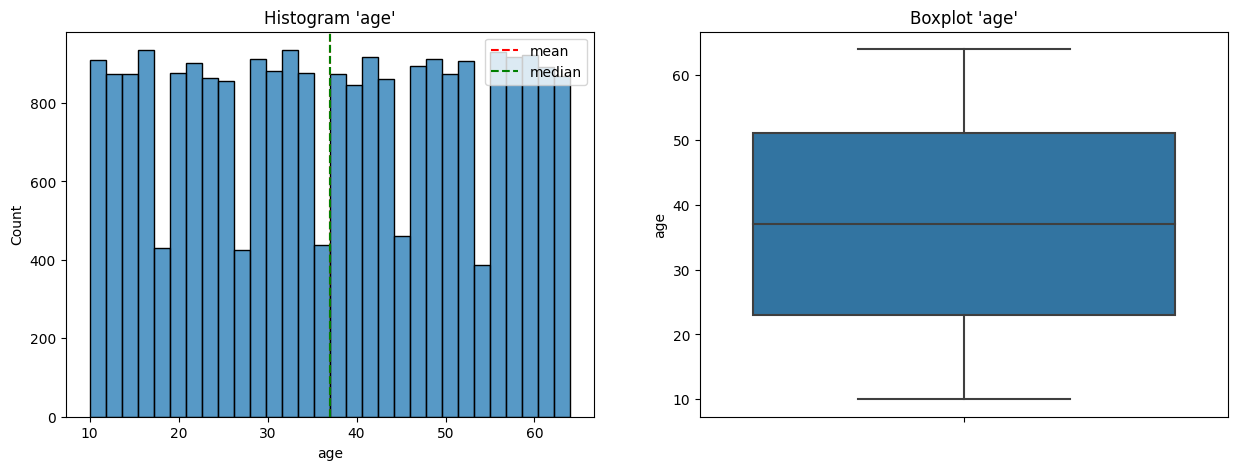

age Kurtosis: -1.205768742655235
age Skewness: -0.007012234860971377
Columns 'age' normal distribution
percentage:  0.0 %


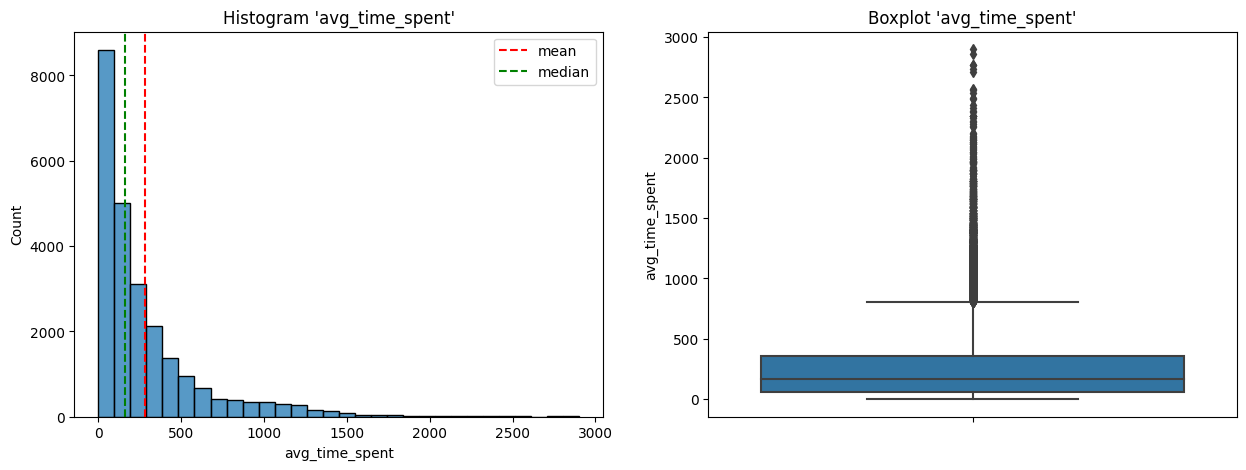

avg_time_spent Kurtosis: 6.2270260867576255
avg_time_spent Skewness: 2.250020184104535
Columns 'avg_time_spent' extreme right skewed
percentage:  2.4123972686756345 %
upper:  1249.6899999999998
lower:  -830.43


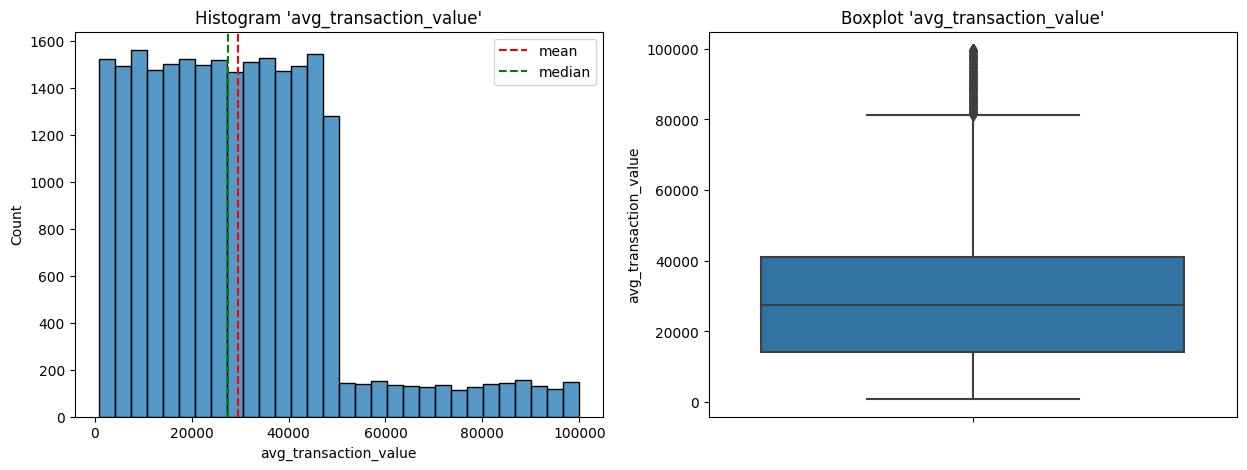

avg_transaction_value Kurtosis: 1.379871112928249
avg_transaction_value Skewness: 1.0261615456570943
Columns 'avg_transaction_value' extreme right skewed
percentage:  0.0 %
upper:  121492.24
lower:  -66315.87


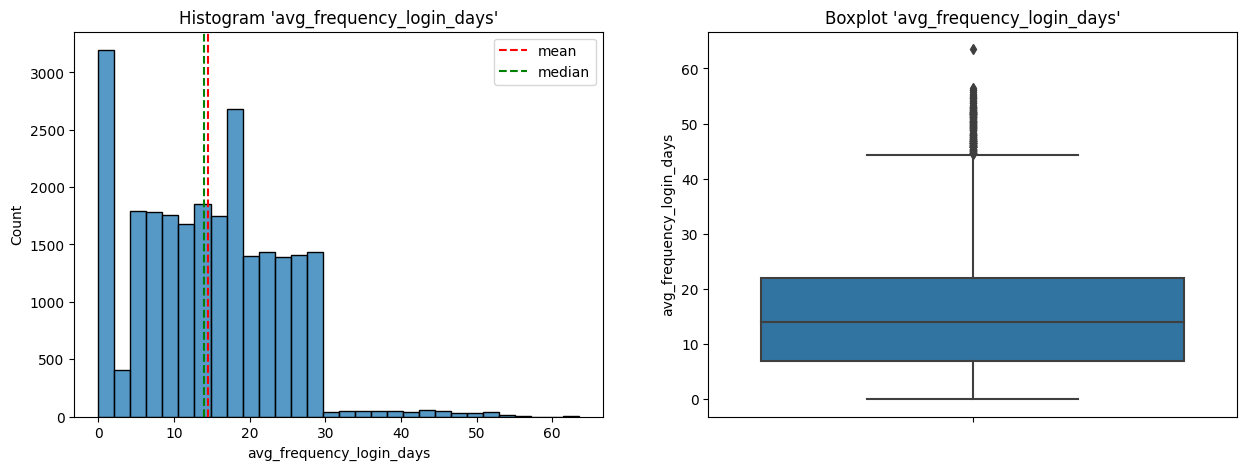

avg_frequency_login_days Kurtosis: 0.24141901182143055
avg_frequency_login_days Skewness: 0.3976165967108557
Columns 'avg_frequency_login_days' normal distribution
percentage:  0.8504722574314103 %


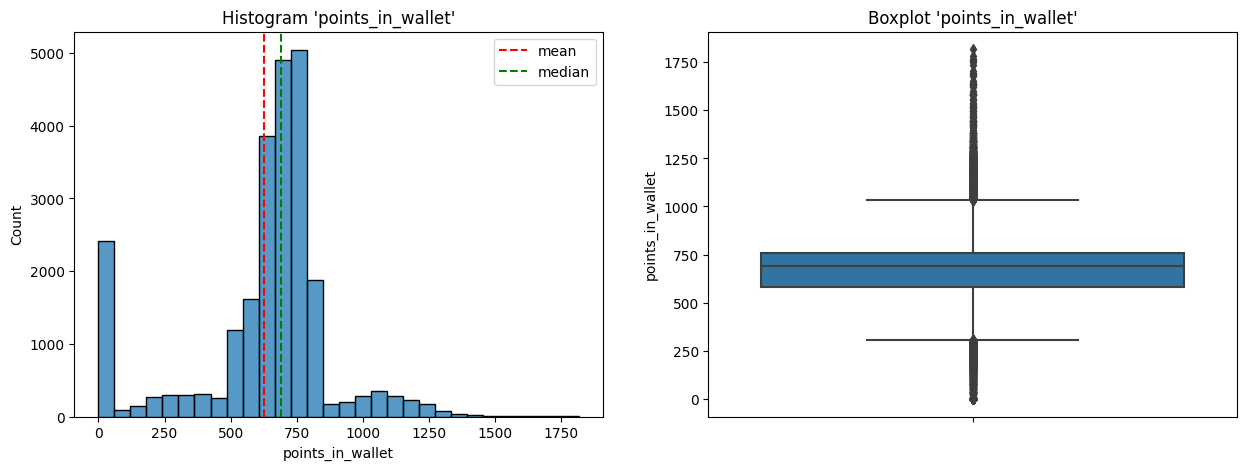

points_in_wallet Kurtosis: 1.3438270043136513
points_in_wallet Skewness: -0.798798212046656
Columns 'points_in_wallet' extreme left skewed
percentage:  10.299709694565973 %
upper:  1305.37
lower:  34.66000000000008


In [38]:
for x in df_num:
    plot_dist(df_num, x)

Handle Outlier:
- Normal
    - avg_frequency_login_days (Standard Scaler)
- Skew
    - avg_time_spent (ekstreme right skewed)
    - avg_transaction_value (ekstreme right skewed)
    - points_in_wallet (extreme left skew)

In [39]:
#Scaling only use StandardScaler
num_cols_1 = ['age']

#Scaling use RobustScaler and winsorize use iqr fold 3 because extreme skewed
num_cols_2 = ['avg_time_spent', 'avg_transaction_value', 'points_in_wallet']

#Scaling use StandardScaler and winsorize use gaussian
num_cols_3 = ['avg_frequency_login_days']

In [40]:
df_num1 = X_train_eda[num_cols_1]
df_num2 = X_train_eda[num_cols_2]
df_num3 = X_train_eda[num_cols_3]

In [41]:
scaler1 = StandardScaler()
df_num1 = pd.DataFrame(scaler1.fit_transform(df_num1), columns=num_cols_1)
df_num1.head()

,age
0,-0.946069
1,-0.946069
2,0.563289
3,-1.323409
4,0.751958


In [42]:
wins2 = Winsorizer(capping_method='iqr', tail='both', fold=3)
scaler2 = RobustScaler()
df_num2 = wins2.fit_transform(df_num2)
df_num2 = scaler2.fit_transform(df_num2)
df_num2 = pd.DataFrame(df_num2, columns=num_cols_2)
df_num2.head()


,avg_time_spent,avg_transaction_value,points_in_wallet
0,0.823462,2.606170,0.358343
1,0.625387,-0.840914,-2.658559
2,0.678894,-0.814422,-0.680659
3,-0.300478,1.098450,0.134633
4,-0.038161,-0.387412,-0.276263


In [43]:
wins3 =Winsorizer(capping_method='gaussian', tail='both')
scaler3 = StandardScaler()
df_num3 = wins3.fit_transform(df_num3)
df_num3 = scaler3.fit_transform(df_num3)
df_num3 = pd.DataFrame(df_num3, columns=num_cols_3)
df_num3.head()

,avg_frequency_login_days
0,-0.160279
1,-1.556954
2,-0.804898
3,0.484341
4,0.054594


## Encoding categorical data

In [44]:
cat_cols_1 = ['membership_category']
cat_cols_2 = ['joining_date', 'last_visit_time', 'days_since_last_login']
cat_cols_3 = [
    'gender', 'region_category', 'joined_through_referral', 'preferred_offer_types',
    'medium_of_operation', 'internet_option', 'used_special_discount',
    'offer_application_preference', 'past_complaint', 'complaint_status',
    'feedback'
]

In [45]:
df_category1 = X_train_eda[cat_cols_1]
df_category2 = X_train_eda[cat_cols_2]
df_category3 = X_train_eda[cat_cols_3]

In [46]:
members_rank = ['No Membership', 'Basic Membership', 'Premium Membership', 'Silver Membership', 'Gold Membership', 'Platinum Membership']

ord_enc = OrdinalEncoder(categories=[members_rank])
df_category1 = pd.DataFrame(ord_enc.fit_transform(df_category1))
df_category1.columns = ord_enc.get_feature_names_out()
df_category1.head()

,membership_category
0,2.0
1,3.0
2,0.0
3,5.0
4,0.0


In [47]:
df_category2.reset_index(drop=True, inplace=True)
df_category2.head()

,joining_date,last_visit_time,days_since_last_login
0,2017,7,6
1,2017,21,6
2,2015,1,10
3,2016,14,9
4,2017,11,13


In [48]:
imputer = SimpleImputer(strategy='most_frequent')
df_category3 = pd.DataFrame(imputer.fit_transform(df_category3))
df_category3.columns = imputer.get_feature_names_out()
df_category3.head()

,gender,region_category,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback
0,F,Town,No,Without Offers,Smartphone,Mobile_Data,No,Yes,No,Not Applicable,Reasonable Price
1,M,City,Yes,Without Offers,Both,Fiber_Optic,Yes,No,No,Not Applicable,Poor Customer Service
2,M,Town,No,Gift Vouchers/Coupons,Desktop,Fiber_Optic,No,Yes,No,Not Applicable,Poor Customer Service
3,F,Town,No,Credit/Debit Card Offers,Desktop,Mobile_Data,No,Yes,No,Not Applicable,Reasonable Price
4,M,City,Yes,Credit/Debit Card Offers,Smartphone,Fiber_Optic,No,Yes,Yes,No Information Available,Poor Product Quality


In [49]:
ohe_enc = OneHotEncoder(sparse_output=False)
df_category3 = pd.DataFrame(ohe_enc.fit_transform(df_category3))
df_category3.columns = ohe_enc.get_feature_names_out()
df_category3.head()

,gender_F,gender_M,region_category_City,region_category_Town,region_category_Village,joined_through_referral_No,joined_through_referral_Yes,preferred_offer_types_Credit/Debit Card Offers,preferred_offer_types_Gift Vouchers/Coupons,preferred_offer_types_Without Offers,medium_of_operation_Both,medium_of_operation_Desktop,medium_of_operation_Smartphone,internet_option_Fiber_Optic,internet_option_Mobile_Data,internet_option_Wi-Fi,used_special_discount_No,used_special_discount_Yes,offer_application_preference_No,offer_application_preference_Yes,past_complaint_No,past_complaint_Yes,complaint_status_No Information Available,complaint_status_Not Applicable,complaint_status_Solved,complaint_status_Solved in Follow-up,complaint_status_Unsolved,feedback_No reason specified,feedback_Poor Customer Service,feedback_Poor Product Quality,feedback_Poor Website,feedback_Products always in Stock,feedback_Quality Customer Care,feedback_Reasonable Price,feedback_Too many ads,feedback_User Friendly Website
0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Check Correlation

In [50]:
#concat all number and target
df_num = pd.concat([df_num1, df_num2, df_num3, y_train.reset_index(drop=True)], axis=1)
df_num.head()

,age,avg_time_spent,avg_transaction_value,points_in_wallet,avg_frequency_login_days,churn_risk_score
0,-0.946069,0.823462,2.606170,0.358343,-0.160279,0
1,-0.946069,0.625387,-0.840914,-2.658559,-1.556954,1
2,0.563289,0.678894,-0.814422,-0.680659,-0.804898,1
3,-1.323409,-0.300478,1.098450,0.134633,0.484341,0
4,0.751958,-0.038161,-0.387412,-0.276263,0.054594,1


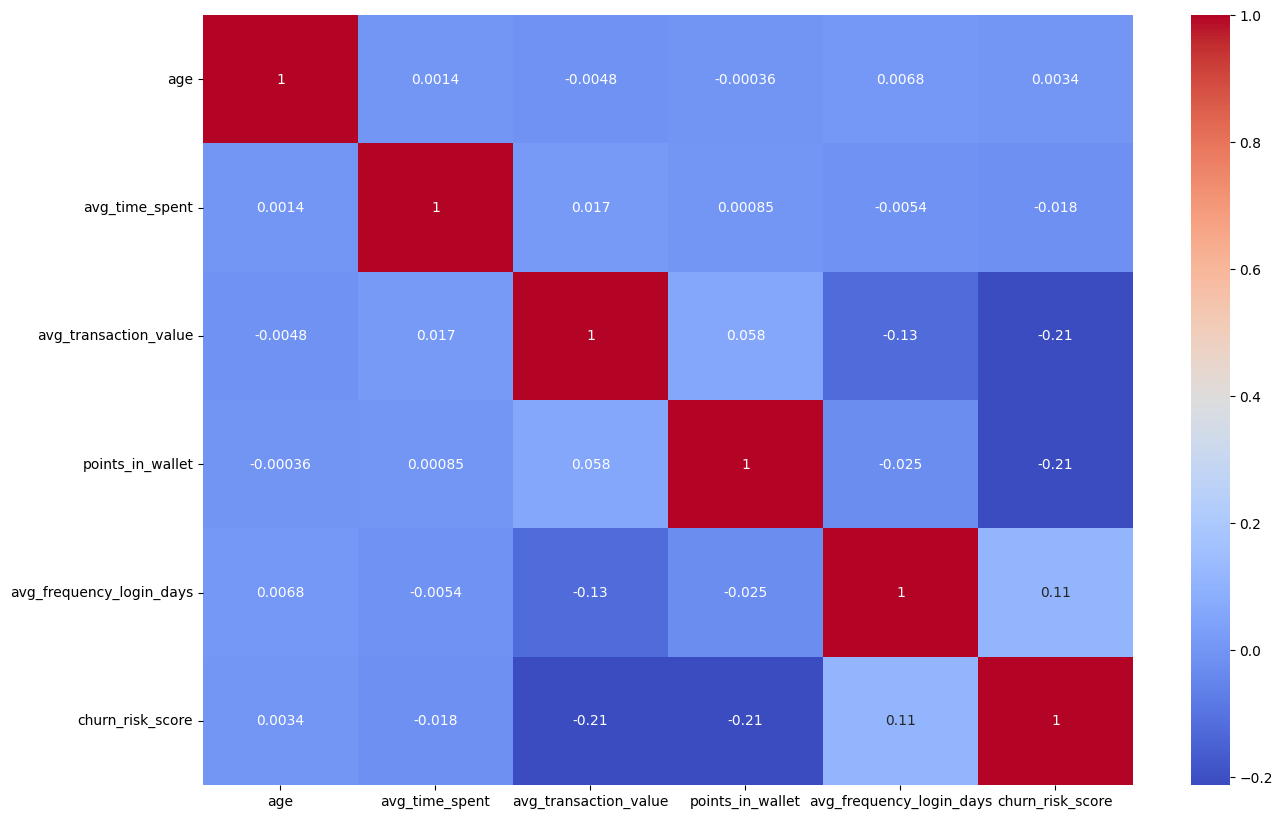

In [51]:
#check correlation
plt.figure(figsize=(15, 10))
sns.heatmap(df_num.corr(), annot=True, cmap='coolwarm')
plt.show()

In [52]:
df_category1 = pd.concat([df_category1,  y_train.reset_index(drop=True)], axis=1)
df_category1.head()

,membership_category,churn_risk_score
0,2.0,0
1,3.0,1
2,0.0,1
3,5.0,0
4,0.0,1


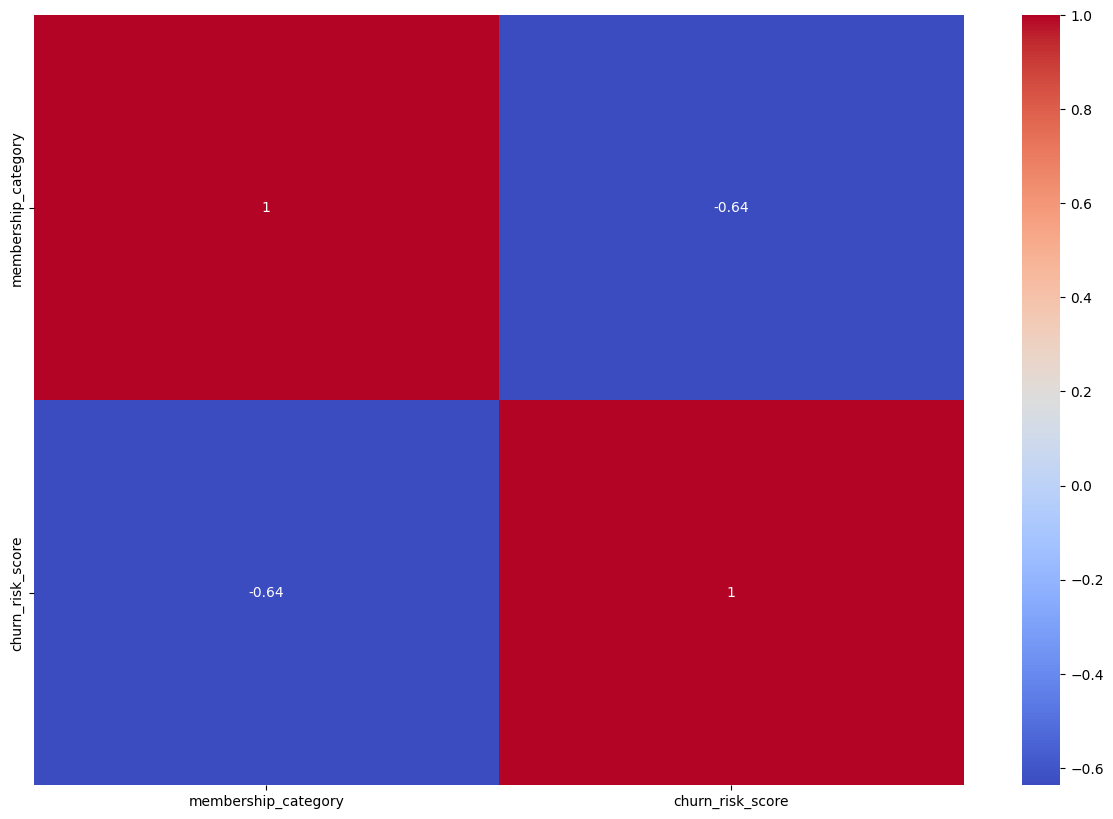

In [53]:
#check correlation
plt.figure(figsize=(15, 10))
sns.heatmap(df_category1.corr(), annot=True, cmap='coolwarm')
plt.show()

In [54]:
df_category2 = pd.concat([df_category2,  y_train.reset_index(drop=True)], axis=1)
df_category2.head()

,joining_date,last_visit_time,days_since_last_login,churn_risk_score
0,2017,7,6,0
1,2017,21,6,1
2,2015,1,10,1
3,2016,14,9,0
4,2017,11,13,1


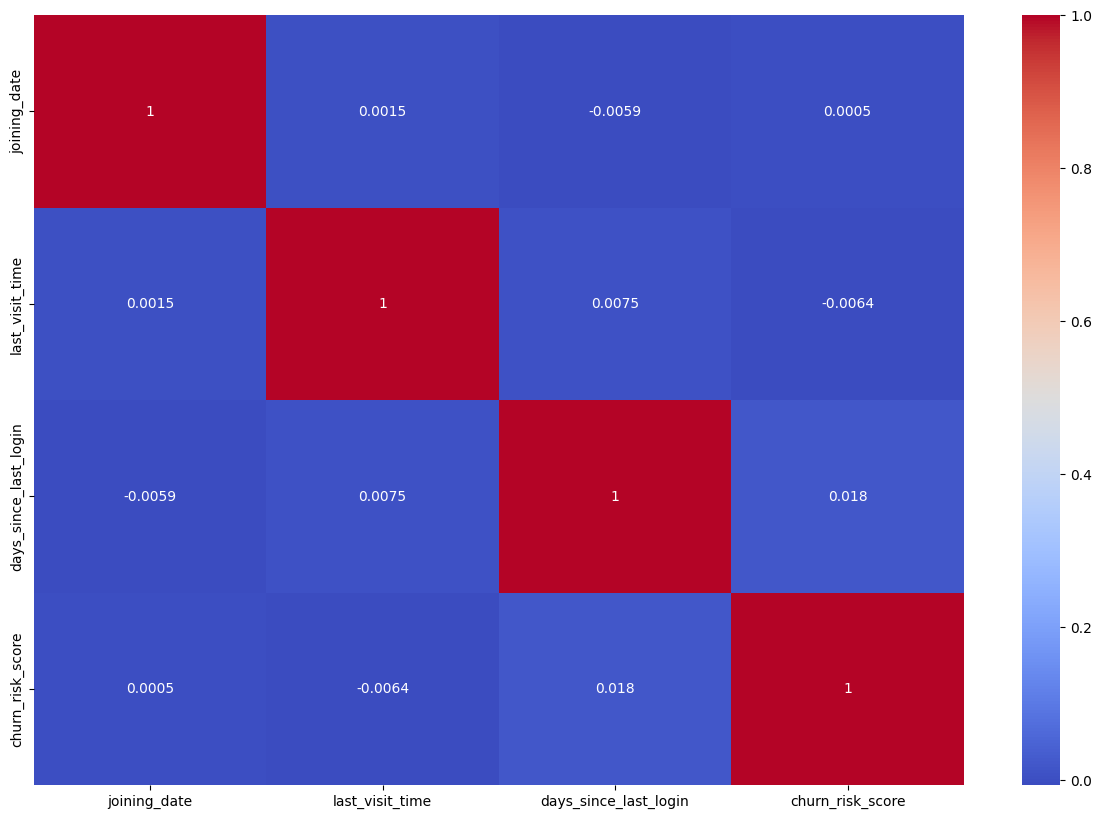

In [55]:
#check correlation
plt.figure(figsize=(15, 10))
sns.heatmap(df_category2.corr(), annot=True, cmap='coolwarm')
plt.show()

In [56]:
df_category3 = pd.concat([df_category3,  y_train.reset_index(drop=True)], axis=1)
df_category3.head()

,gender_F,gender_M,region_category_City,region_category_Town,region_category_Village,joined_through_referral_No,joined_through_referral_Yes,preferred_offer_types_Credit/Debit Card Offers,preferred_offer_types_Gift Vouchers/Coupons,preferred_offer_types_Without Offers,medium_of_operation_Both,medium_of_operation_Desktop,medium_of_operation_Smartphone,internet_option_Fiber_Optic,internet_option_Mobile_Data,internet_option_Wi-Fi,used_special_discount_No,used_special_discount_Yes,offer_application_preference_No,offer_application_preference_Yes,past_complaint_No,past_complaint_Yes,complaint_status_No Information Available,complaint_status_Not Applicable,complaint_status_Solved,complaint_status_Solved in Follow-up,complaint_status_Unsolved,feedback_No reason specified,feedback_Poor Customer Service,feedback_Poor Product Quality,feedback_Poor Website,feedback_Products always in Stock,feedback_Quality Customer Care,feedback_Reasonable Price,feedback_Too many ads,feedback_User Friendly Website,churn_risk_score
0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1


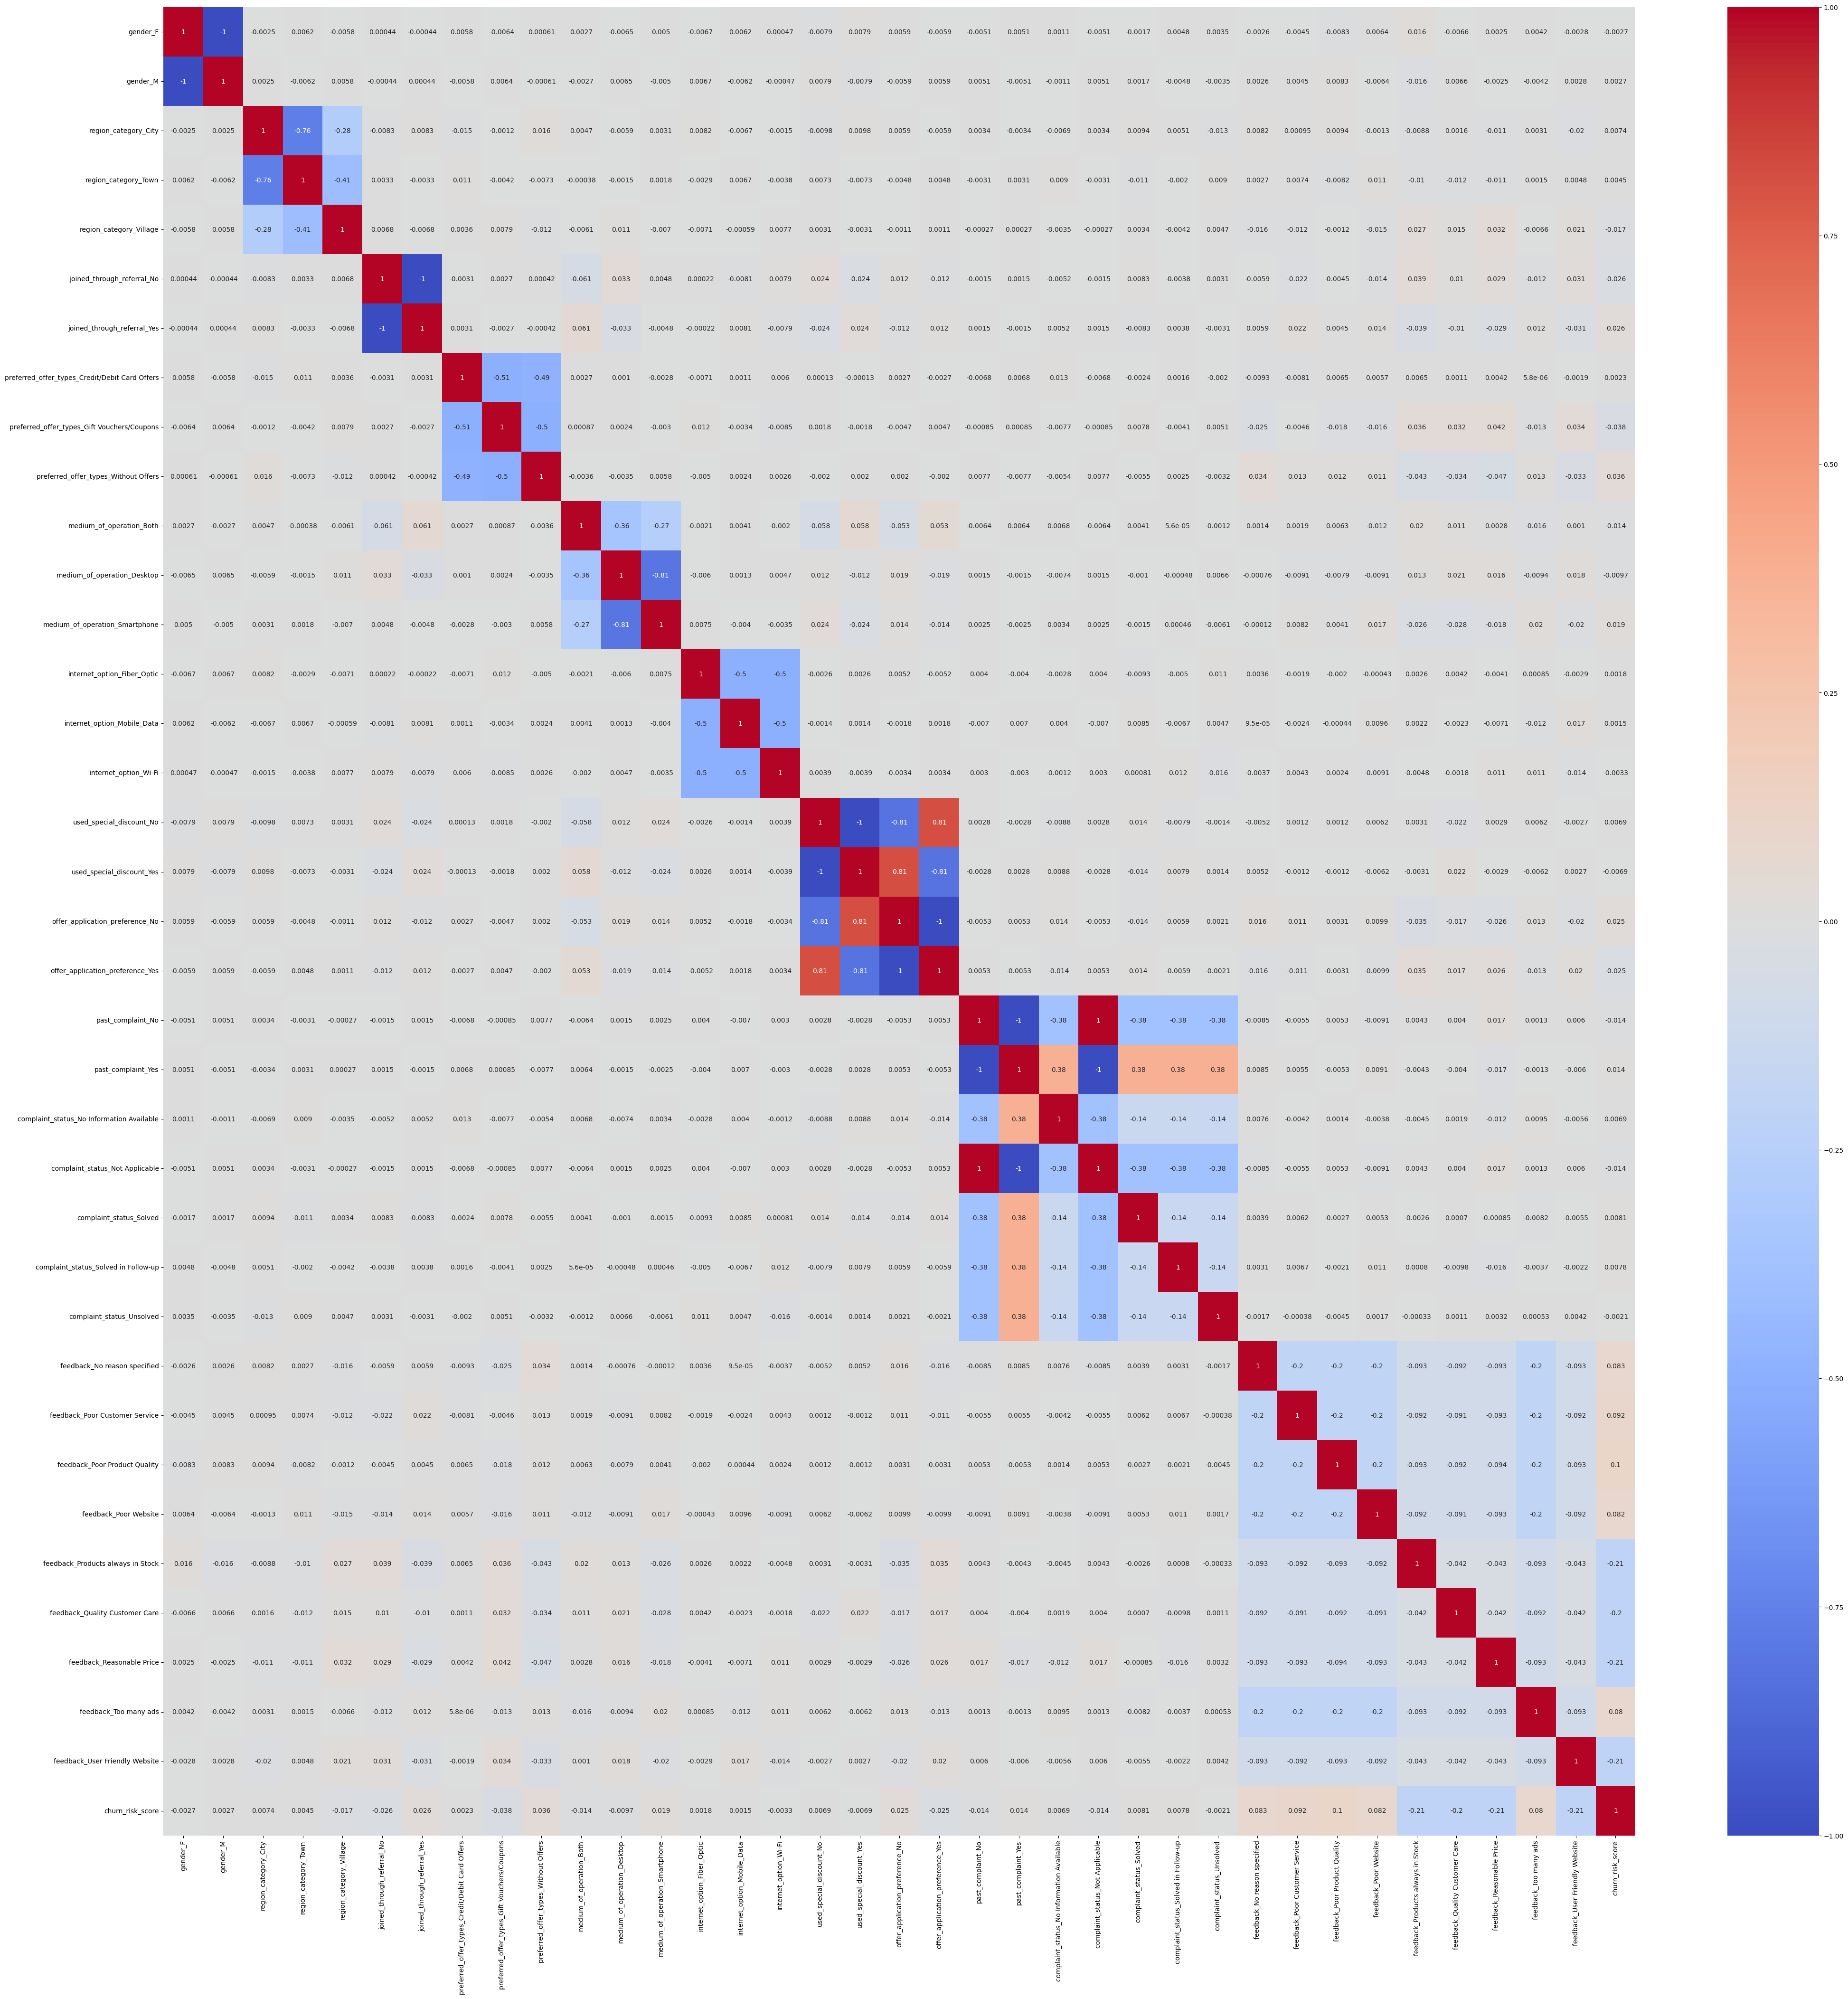

In [57]:
#check correlation
plt.figure(figsize=(50, 50))
sns.heatmap(df_category3.corr(), annot=True, cmap='coolwarm')
plt.show()

## Feature Selection

Berdasarkan hasil korelasi diatas dengan nilai treshold 0,08. Didapatkan feature:
- Numeric
    - avg_transaction_value(IQR)(RobustScaler)
    - points_in_wallet(IQR)(RobustScaler)
    - avg_frequency_login_days(gaussian)(StandarScaler)
<br><br>
- Categoric
    - membership_category (Ordinal Encoder)
    - feedback (Onehot Encoder)

## Pipeline

In [58]:
num_pipe1 = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('wins1', Winsorizer(capping_method='iqr', tail='both', fold=3)),
    ('scaler1', RobustScaler())
])

num_pipe2 = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('wins2', Winsorizer(capping_method='gaussian', tail='both')),
    ('scaler2', StandardScaler())
])

cat_pipe1 = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[members_rank]))
])

cat_pipe2 = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('numeric1', num_pipe1, ['avg_transaction_value', 'points_in_wallet']),
    ('numeric2', num_pipe2, ['avg_frequency_login_days']),
    ('categoric1', cat_pipe1, ['membership_category']),
    ('categoric2', cat_pipe2, ['feedback'])
])

In [59]:
preprocessor

ColumnTransformer(transformers=[('numeric1',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('wins1',
                                                  Winsorizer(capping_method='iqr',
                                                             tail='both')),
                                                 ('scaler1', RobustScaler())]),
                                 ['avg_transaction_value', 'points_in_wallet']),
                                ('numeric2',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('wins2',
                                                  Winsorizer(tail='both...
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['No '
                                                                              'Membership',
                                                                              'Basic '
                                                                              'Membership',
                                                                              'Premium '
                                                                              'Membership',
                                                                              'Silver '
                                                                              'Membership',
                                                                              'Gold '
                                                                              'Membership',
                                                                              'Platinum '
                                                                              'Membership']]))]),
                                 ['membership_category']),
                                ('categoric2',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(sparse_output=False))]),
                                 ['feedback'])])

In [60]:
train_tr = preprocessor.fit_transform(X_train)
val_tr = preprocessor.transform(X_val)
test_tr = preprocessor.transform(X_test)

# Modeling

In [61]:
train_set = tf.data.Dataset.from_tensor_slices((train_tr, y_train))

train_set = train_set.shuffle(buffer_size=2445).batch(32)

val_set = tf.data.Dataset.from_tensor_slices((val_tr, y_val))
val_set = val_set.batch(64)

## Sequential (Base)

**Refrensi** 

**Penentuan jumlah neuron di hidden layer**
<br><br>
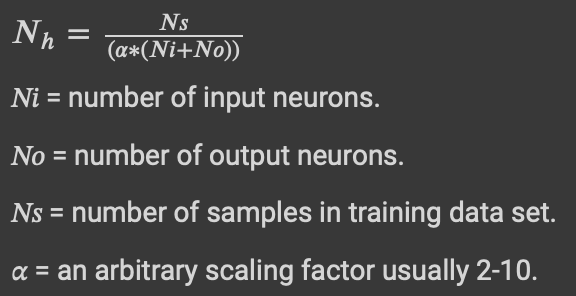

𝑁𝑖 = number of input neurons.

𝑁𝑜 = number of output neurons.

𝑁𝑠 = number of samples in training data set.

𝛼 = an arbitrary scaling factor usually 2-10.

Referensi: https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw



In [62]:
len(train_tr)

24457

In [63]:
alp = 10
inp = train_tr.shape[1]
out = 1
hid = int(len(train_tr)/(alp*(inp+out)))
print(f'Jumlah neuron pada hidden layer: {hid}')

model_seq = tf.keras.models.Sequential([
    tf.keras.layers.Dense(inp, activation='relu', input_shape=(inp,)),
    tf.keras.layers.Dense(hid, activation='relu'),
    tf.keras.layers.Dense(out, activation='sigmoid')
])

model_seq.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_seq.summary()

Jumlah neuron pada hidden layer: 174
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 13)                182       
                                                                 
 dense_1 (Dense)             (None, 174)               2436      
                                                                 
 dense_2 (Dense)             (None, 1)                 175       
                                                                 
Total params: 2793 (10.91 KB)
Trainable params: 2793 (10.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


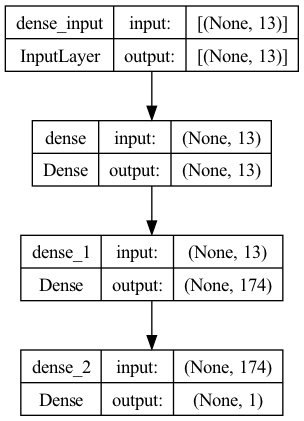

In [64]:
tf.keras.utils.plot_model(model_seq, show_shapes=True)

In [65]:
history_seq = model_seq.fit((train_set), epochs=100, validation_data=(val_set))

Epoch 1/100


765/765 [==============================] - 1s 763us/step - loss: 0.3795 - accuracy: 0.8315 - val_loss: 0.3093 - val_accuracy: 0.8847
Epoch 2/100
765/765 [==============================] - 1s 674us/step - loss: 0.2621 - accuracy: 0.9035 - val_loss: 0.2441 - val_accuracy: 0.9092
Epoch 3/100
765/765 [==============================] - 1s 666us/step - loss: 0.2204 - accuracy: 0.9176 - val_loss: 0.2174 - val_accuracy: 0.9132
Epoch 4/100
765/765 [==============================] - 1s 729us/step - loss: 0.1992 - accuracy: 0.9257 - val_loss: 0.2034 - val_accuracy: 0.9191
Epoch 5/100
765/765 [==============================] - 1s 708us/step - loss: 0.1868 - accuracy: 0.9298 - val_loss: 0.1944 - val_accuracy: 0.9236
Epoch 6/100
765/765 [==============================] - 1s 680us/step - loss: 0.1807 - accuracy: 0.9302 - val_loss: 0.1985 - val_accuracy: 0.9256
Epoch 7/100
765/765 [==============================] - 1s 717us/step - loss: 0.1755 - accuracy: 0.9313 - val_loss: 0.1872 - val_accuracy: 0.92

Text(0.5, 0, 'Epoch')

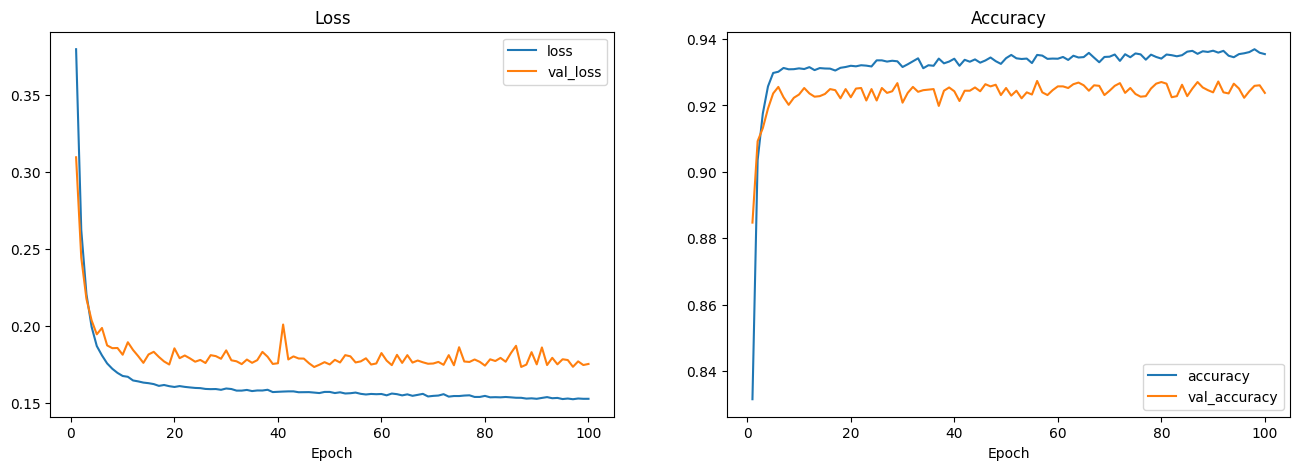

In [66]:
epoch=100

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epoch+1),history_seq.history['loss'],label='loss')
ax[0].plot(range(1,epoch+1),history_seq.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')
#ax[0].set_ylim(0,0.01)

ax[1].plot(range(1,epoch+1),history_seq.history['accuracy'],label='accuracy')
ax[1].plot(range(1,epoch+1),history_seq.history['val_accuracy'],label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')
#ax[1].set_ylim(0.5,1.5)

In [67]:
#print accuracy and loss on train and test
print('Train Accuracy: ', model_seq.evaluate(train_tr, y_train)[1])
print('Test Accuracy: ', model_seq.evaluate(test_tr, y_test)[1])


765/765 [==============================] - 0s 408us/step - loss: 0.1494 - accuracy: 0.9380
Train Accuracy:  0.9380136728286743
107/107 [==============================] - 0s 403us/step - loss: 0.1583 - accuracy: 0.9355
Test Accuracy:  0.9355313777923584


In [68]:
#predict
y_pred_train = model_seq.predict(train_tr)

765/765 [==============================] - 0s 297us/step


In [69]:
y_pred_test = model_seq.predict(test_tr)

107/107 [==============================] - 0s 788us/step


In [70]:
y_pred_train = np.where(y_pred_train > 0.5, 1, 0)
y_pred_test = np.where(y_pred_test > 0.5, 1, 0)

In [71]:
print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94     12225
           1       0.93      0.95      0.94     12232

    accuracy                           0.94     24457
   macro avg       0.94      0.94      0.94     24457
weighted avg       0.94      0.94      0.94     24457

              precision    recall  f1-score   support

           0       0.94      0.93      0.93      1698
           1       0.93      0.94      0.94      1699

    accuracy                           0.94      3397
   macro avg       0.94      0.94      0.94      3397
weighted avg       0.94      0.94      0.94      3397



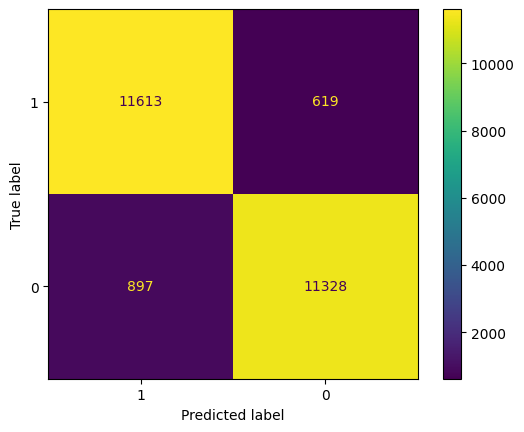

In [72]:
#confusion matrix train
cm = confusion_matrix(y_train, y_pred_train, labels=[1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,0])
disp.plot()

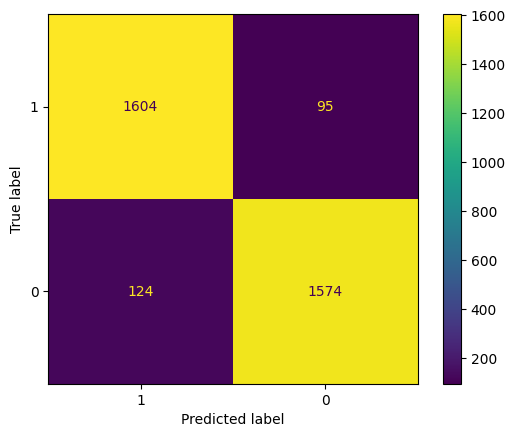

In [73]:
#confusion matrix test
cm = confusion_matrix(y_test, y_pred_test, labels=[1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,0])
disp.plot()

Model overfit when viewed from the graph plot. The accuracy value is higher than the val accuracy.

## Sequential (Tuned)

Replaced the alp and dense values in each hidden layer. Also added a 20% dropout in each hidden layer.

In [74]:
alp = 5
inp = train_tr.shape[1]
out = 1
hid1 = 30
hid2 = 20

print(f'Jumlah neuron pada hidden layer: {hid1}')
print(f'Jumlah neuron pada hidden layer: {hid2}')


model_seq_tuned = tf.keras.models.Sequential([
    tf.keras.layers.Dense(inp, activation='relu', input_shape=(inp,)),
    tf.keras.layers.Dropout(0.2), #dropout 20%
    tf.keras.layers.Dense(hid1, activation='relu'),
    tf.keras.layers.Dropout(0.2), #dropout 20%
    tf.keras.layers.Dense(hid2, activation='relu'),
    tf.keras.layers.Dropout(0.2), #dropout 20%
    tf.keras.layers.Dense(out, activation='sigmoid')
])

model_seq_tuned.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_seq_tuned.summary()

Jumlah neuron pada hidden layer: 30
Jumlah neuron pada hidden layer: 20
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 13)                182       
                                                                 
 dropout (Dropout)           (None, 13)                0         
                                                                 
 dense_4 (Dense)             (None, 30)                420       
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 dense_5 (Dense)             (None, 20)                620       
                                                                 
 dropout_2 (Dropout)         (None, 20)                0         
                                                

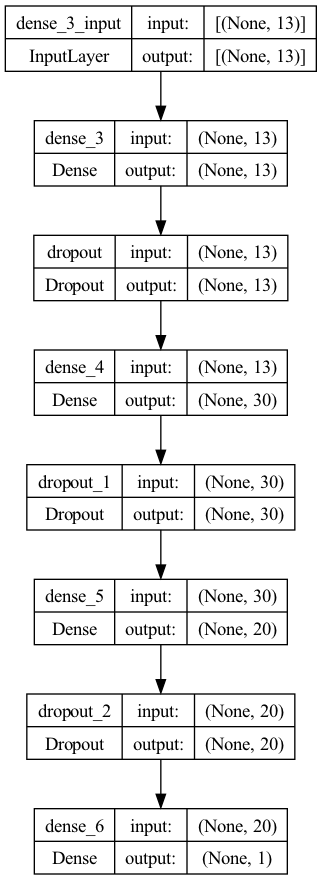

In [75]:
tf.keras.utils.plot_model(model_seq_tuned, show_shapes=True)

In [76]:
history_seq_tuned = model_seq_tuned.fit((train_set), epochs=100, validation_data=(val_set))

Epoch 1/100


765/765 [==============================] - 1s 909us/step - loss: 0.4598 - accuracy: 0.7880 - val_loss: 0.3431 - val_accuracy: 0.8466
Epoch 2/100
765/765 [==============================] - 1s 824us/step - loss: 0.3530 - accuracy: 0.8467 - val_loss: 0.3015 - val_accuracy: 0.8793
Epoch 3/100
765/765 [==============================] - 1s 957us/step - loss: 0.3184 - accuracy: 0.8690 - val_loss: 0.2691 - val_accuracy: 0.9014
Epoch 4/100
765/765 [==============================] - 1s 817us/step - loss: 0.2857 - accuracy: 0.8874 - val_loss: 0.2382 - val_accuracy: 0.9112
Epoch 5/100
765/765 [==============================] - 1s 941us/step - loss: 0.2564 - accuracy: 0.9026 - val_loss: 0.2190 - val_accuracy: 0.9146
Epoch 6/100
765/765 [==============================] - 1s 811us/step - loss: 0.2375 - accuracy: 0.9100 - val_loss: 0.2051 - val_accuracy: 0.9200
Epoch 7/100
765/765 [==============================] - 1s 802us/step - loss: 0.2242 - accuracy: 0.9132 - val_loss: 0.2015 - val_accuracy: 0.92

Text(0.5, 0, 'Epoch')

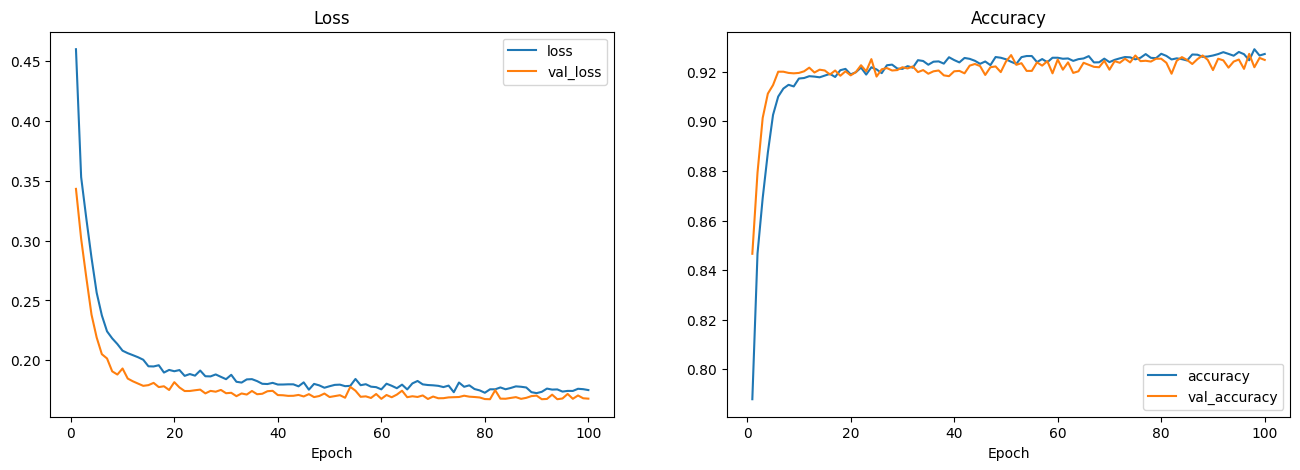

In [77]:
epoch=100

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epoch+1),history_seq_tuned.history['loss'],label='loss')
ax[0].plot(range(1,epoch+1),history_seq_tuned.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')
#ax[0].set_ylim(0,0.01)

ax[1].plot(range(1,epoch+1),history_seq_tuned.history['accuracy'],label='accuracy')
ax[1].plot(range(1,epoch+1),history_seq_tuned.history['val_accuracy'],label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')
#ax[1].set_ylim(0.5,1.5)

In [78]:
#print accuracy and loss on train and test
print('Train Accuracy: ', model_seq_tuned.evaluate(train_tr, y_train)[1])
print('Test Accuracy: ', model_seq_tuned.evaluate(test_tr, y_test)[1])


765/765 [==============================] - 1s 736us/step - loss: 0.1536 - accuracy: 0.9345
Train Accuracy:  0.9344564080238342
107/107 [==============================] - 0s 1ms/step - loss: 0.1529 - accuracy: 0.9341
Test Accuracy:  0.9340594410896301


In [79]:
y_pred_train = model_seq_tuned.predict(train_tr)

765/765 [==============================] - 0s 366us/step


In [80]:
y_pred_test = model_seq_tuned.predict(test_tr)

  1/107 [..............................] - ETA: 1s

107/107 [==============================] - 0s 456us/step


In [81]:
y_pred_train = np.where(y_pred_train > 0.5, 1, 0)
y_pred_test = np.where(y_pred_test > 0.5, 1, 0)

In [82]:
print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93     12225
           1       0.94      0.93      0.93     12232

    accuracy                           0.93     24457
   macro avg       0.93      0.93      0.93     24457
weighted avg       0.93      0.93      0.93     24457

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1698
           1       0.94      0.93      0.93      1699

    accuracy                           0.93      3397
   macro avg       0.93      0.93      0.93      3397
weighted avg       0.93      0.93      0.93      3397



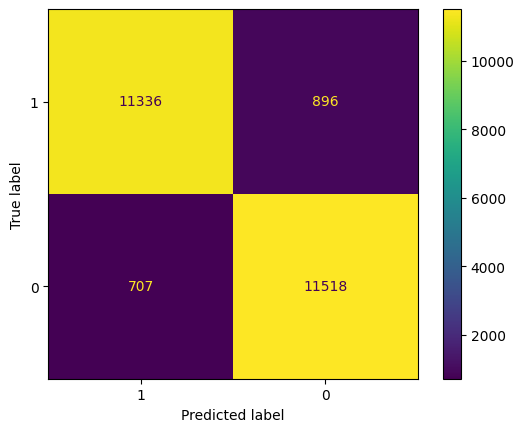

In [83]:
#confusion matrix train
cm = confusion_matrix(y_train, y_pred_train, labels=[1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,0])
disp.plot()

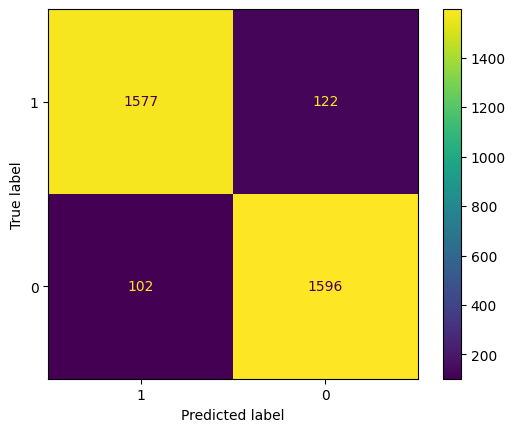

In [84]:
#confusion matrix test
cm = confusion_matrix(y_test, y_pred_test, labels=[1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,0])
disp.plot()

When viewed from the graph, the accuracy and val accuracy values are quite close. When viewed from the loss value, the loss value is above val loss. This indicates that the data is not overfitting.

## Functional (Base)

In [85]:
# functional API
input_layer= tf.keras.Input(shape=(train_tr.shape[1:]),name='input_layer')

hidden_1= Dense(30, activation='relu', name='hidden_1')(input_layer) #hidden layer 1
hidden_2= Dense(30, activation='relu', name='hidden_2')(hidden_1) #hidden layer 2
hidden_3= Dense(10, activation='relu', name='hidden_3')(hidden_2) #hidden layer 3
concat= tf.keras.layers.concatenate([input_layer,hidden_3])

output_layer= Dense(1, activation='sigmoid', name='output_layer')(concat)

model_func= Model(inputs=input_layer,
                outputs=output_layer)

model_func.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [86]:
model_func.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 13)]                 0         []                            
                                                                                                  
 hidden_1 (Dense)            (None, 30)                   420       ['input_layer[0][0]']         
                                                                                                  
 hidden_2 (Dense)            (None, 30)                   930       ['hidden_1[0][0]']            
                                                                                                  
 hidden_3 (Dense)            (None, 10)                   310       ['hidden_2[0][0]']            
                                                                                              

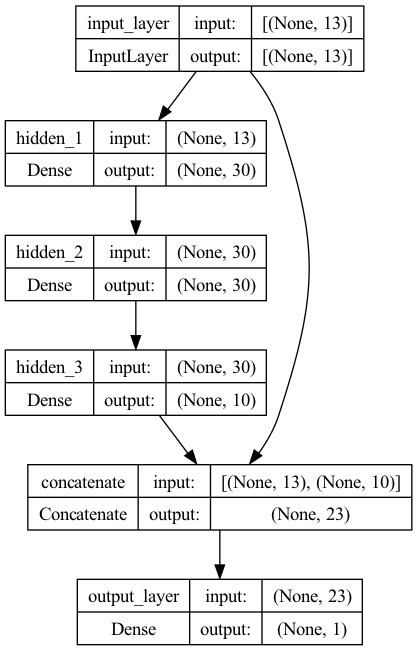

In [87]:
tf.keras.utils.plot_model(model_func, show_shapes=True)

Mengggunakan 3 hidden layer. Pada layer 1 dan 2 menggunakan jumlah neuron sebanyak 30. Pada hidden layer ke 3 menggunakan neuron sebanyak 10.

In [88]:
history_func = model_func.fit((train_set), epochs=100, validation_data=(val_set))

Epoch 1/100
765/765 [==============================] - 1s 817us/step - loss: 0.3615 - accuracy: 0.8373 - val_loss: 0.2760 - val_accuracy: 0.8989
Epoch 2/100
765/765 [==============================] - 1s 730us/step - loss: 0.2359 - accuracy: 0.9160 - val_loss: 0.2285 - val_accuracy: 0.9110
Epoch 3/100
765/765 [==============================] - 1s 702us/step - loss: 0.2107 - accuracy: 0.9219 - val_loss: 0.2142 - val_accuracy: 0.9197
Epoch 4/100
765/765 [==============================] - 1s 694us/step - loss: 0.1969 - accuracy: 0.9274 - val_loss: 0.2042 - val_accuracy: 0.9230
Epoch 5/100
765/765 [==============================] - 1s 750us/step - loss: 0.1880 - accuracy: 0.9309 - val_loss: 0.2023 - val_accuracy: 0.9164
Epoch 6/100
765/765 [==============================] - 1s 655us/step - loss: 0.1801 - accuracy: 0.9319 - val_loss: 0.1924 - val_accuracy: 0.9241
Epoch 7/100
765/765 [==============================] - 1s 755us/step - loss: 0.1738 - accuracy: 0.9325 - val_loss: 0.1952 - val_ac

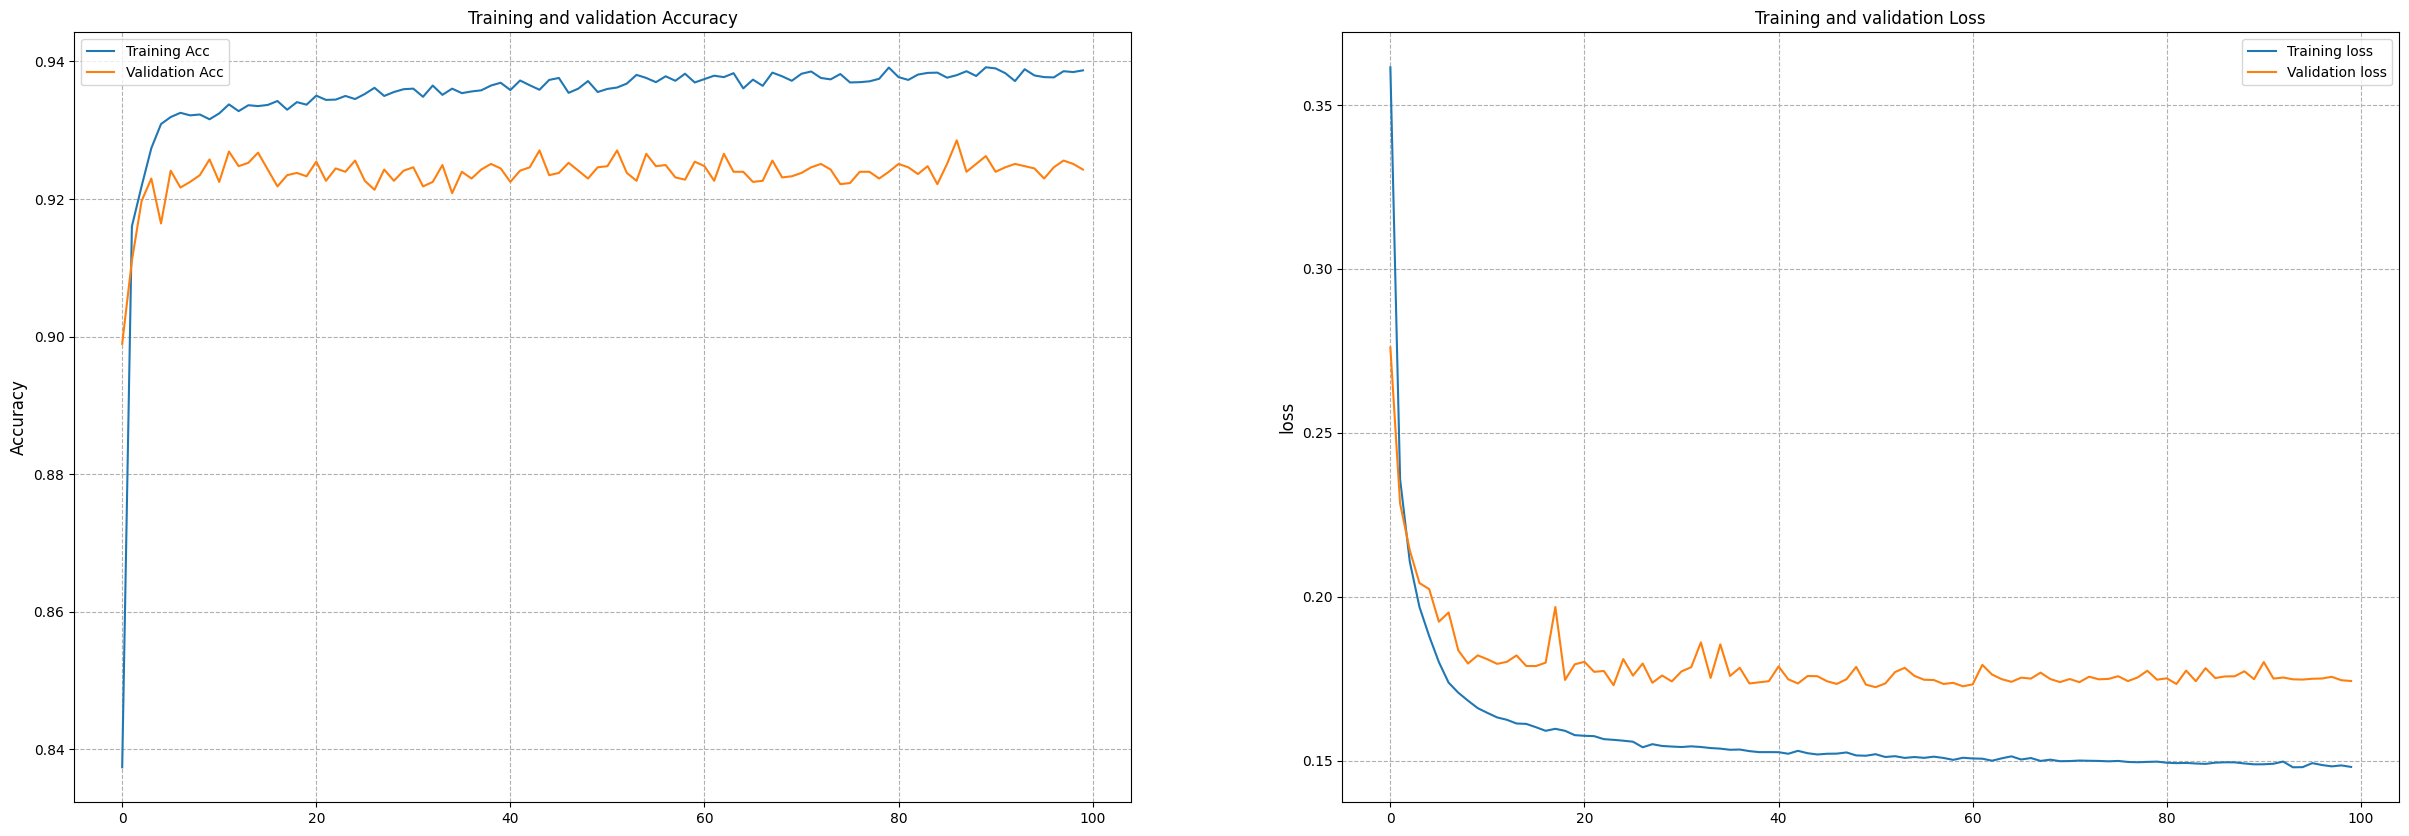

In [89]:
fig,ax= plt.subplots(1,2 , figsize=(30,10))

plt.subplot(1,2,1)
plt.title('Training and validation Accuracy', fontsize=12)
plt.plot(history_func.history['accuracy'], label='Training Acc')
plt.plot(history_func.history['val_accuracy'], label='Validation Acc')
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(linestyle='--')

plt.subplot(1,2,2)
plt.title('Training and validation Loss', fontsize=12)
plt.plot(history_func.history['loss'], label='Training loss')
plt.plot(history_func.history['val_loss'], label='Validation loss')
plt.ylabel('loss', fontsize=12)
plt.legend()
plt.grid(linestyle='--')
plt.show()

In [90]:
#print accuracy and loss on train and test
print('Train Accuracy: ', model_func.evaluate(train_tr, y_train)[1])
print('Test Accuracy: ', model_func.evaluate(test_tr, y_test)[1])


765/765 [==============================] - 0s 396us/step - loss: 0.1449 - accuracy: 0.9400
Train Accuracy:  0.9399762749671936
107/107 [==============================] - 0s 385us/step - loss: 0.1574 - accuracy: 0.9320
Test Accuracy:  0.9319988489151001


In [91]:
#predict
y_pred_train = model_func.predict(train_tr)

765/765 [==============================] - 0s 360us/step


In [92]:
y_pred_test = model_func.predict(test_tr)

107/107 [==============================] - 0s 347us/step


In [93]:
y_pred_train = np.where(y_pred_train > 0.5, 1, 0)
y_pred_test = np.where(y_pred_test > 0.5, 1, 0)

In [94]:
print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94     12225
           1       0.93      0.95      0.94     12232

    accuracy                           0.94     24457
   macro avg       0.94      0.94      0.94     24457
weighted avg       0.94      0.94      0.94     24457

              precision    recall  f1-score   support

           0       0.94      0.93      0.93      1698
           1       0.93      0.94      0.93      1699

    accuracy                           0.93      3397
   macro avg       0.93      0.93      0.93      3397
weighted avg       0.93      0.93      0.93      3397



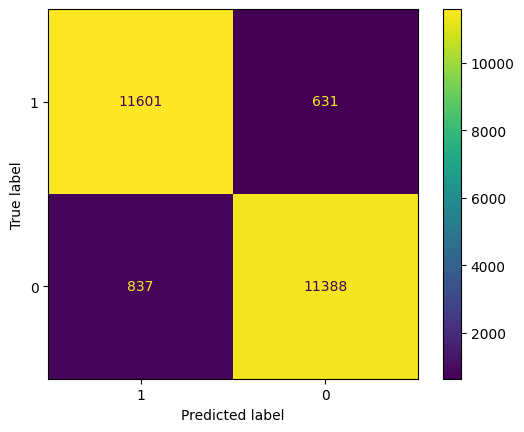

In [95]:
#confusion matrix train
cm = confusion_matrix(y_train, y_pred_train, labels=[1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,0])
disp.plot()

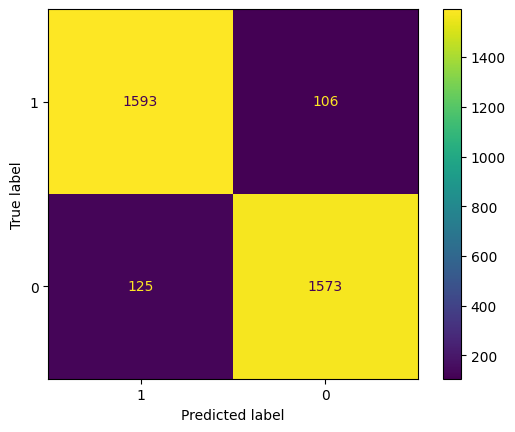

In [96]:
#confusion matrix test
cm = confusion_matrix(y_test, y_pred_test, labels=[1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,0])
disp.plot()

The model has an overfit, seen from the val accuracy value which is lower than the accuracy.

## Functional (Tuned)

Melakukan hyperparameter tuning dengan menambahkan dropout pada setiap hidden layer sebesar 20%.

In [97]:
# functional API
input_layer = tf.keras.Input(shape=(train_tr.shape[1:]), name='input_layer')

hidden_1 = Dense(30, activation='relu', name='hidden_1')(input_layer)
dropout_1 = Dropout(0.2, name='dropout_1')(hidden_1)  # Dropout pada hidden layer 1

hidden_2 = Dense(30, activation='relu', name='hidden_2')(dropout_1)
dropout_2 = Dropout(0.2, name='dropout_2')(hidden_2)  # Dropout pada hidden layer 2

hidden_3 = Dense(10, activation='relu', name='hidden_3')(dropout_2)
dropout_3 = Dropout(0.2, name='dropout_3')(hidden_3)  # Dropout pada hidden layer 3

concat = tf.keras.layers.concatenate([input_layer, dropout_3])

output_layer = Dense(1, activation='sigmoid', name='output_layer')(concat)

model_func_tuned = Model(inputs=input_layer, outputs=output_layer)

model_func_tuned.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [98]:
model_func_tuned.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 13)]                 0         []                            
                                                                                                  
 hidden_1 (Dense)            (None, 30)                   420       ['input_layer[0][0]']         
                                                                                                  
 dropout_1 (Dropout)         (None, 30)                   0         ['hidden_1[0][0]']            
                                                                                                  
 hidden_2 (Dense)            (None, 30)                   930       ['dropout_1[0][0]']           
                                                                                            

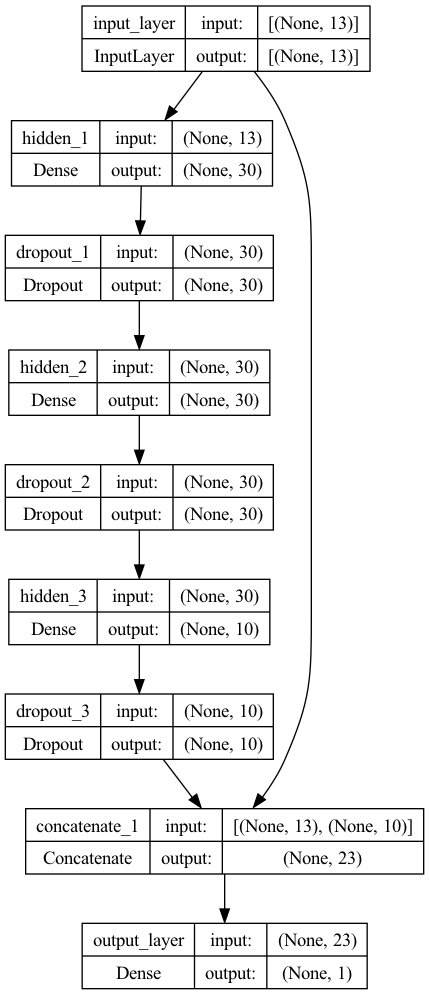

In [99]:
tf.keras.utils.plot_model(model_func_tuned, show_shapes=True)

In [100]:
history_func_tuned = model_func_tuned.fit((train_set), epochs=100, validation_data=(val_set))

Epoch 1/100
765/765 [==============================] - 1s 758us/step - loss: 0.4689 - accuracy: 0.7703 - val_loss: 0.3431 - val_accuracy: 0.8527
Epoch 2/100
765/765 [==============================] - 1s 750us/step - loss: 0.3572 - accuracy: 0.8424 - val_loss: 0.3283 - val_accuracy: 0.8567
Epoch 3/100
765/765 [==============================] - 1s 767us/step - loss: 0.3364 - accuracy: 0.8547 - val_loss: 0.3104 - val_accuracy: 0.8610
Epoch 4/100
765/765 [==============================] - 1s 680us/step - loss: 0.3159 - accuracy: 0.8601 - val_loss: 0.2755 - val_accuracy: 0.8639
Epoch 5/100
765/765 [==============================] - 1s 672us/step - loss: 0.2843 - accuracy: 0.8841 - val_loss: 0.2349 - val_accuracy: 0.9163
Epoch 6/100
765/765 [==============================] - 1s 740us/step - loss: 0.2593 - accuracy: 0.8984 - val_loss: 0.2147 - val_accuracy: 0.9187
Epoch 7/100
765/765 [==============================] - 1s 670us/step - loss: 0.2426 - accuracy: 0.9019 - val_loss: 0.2015 - val_ac

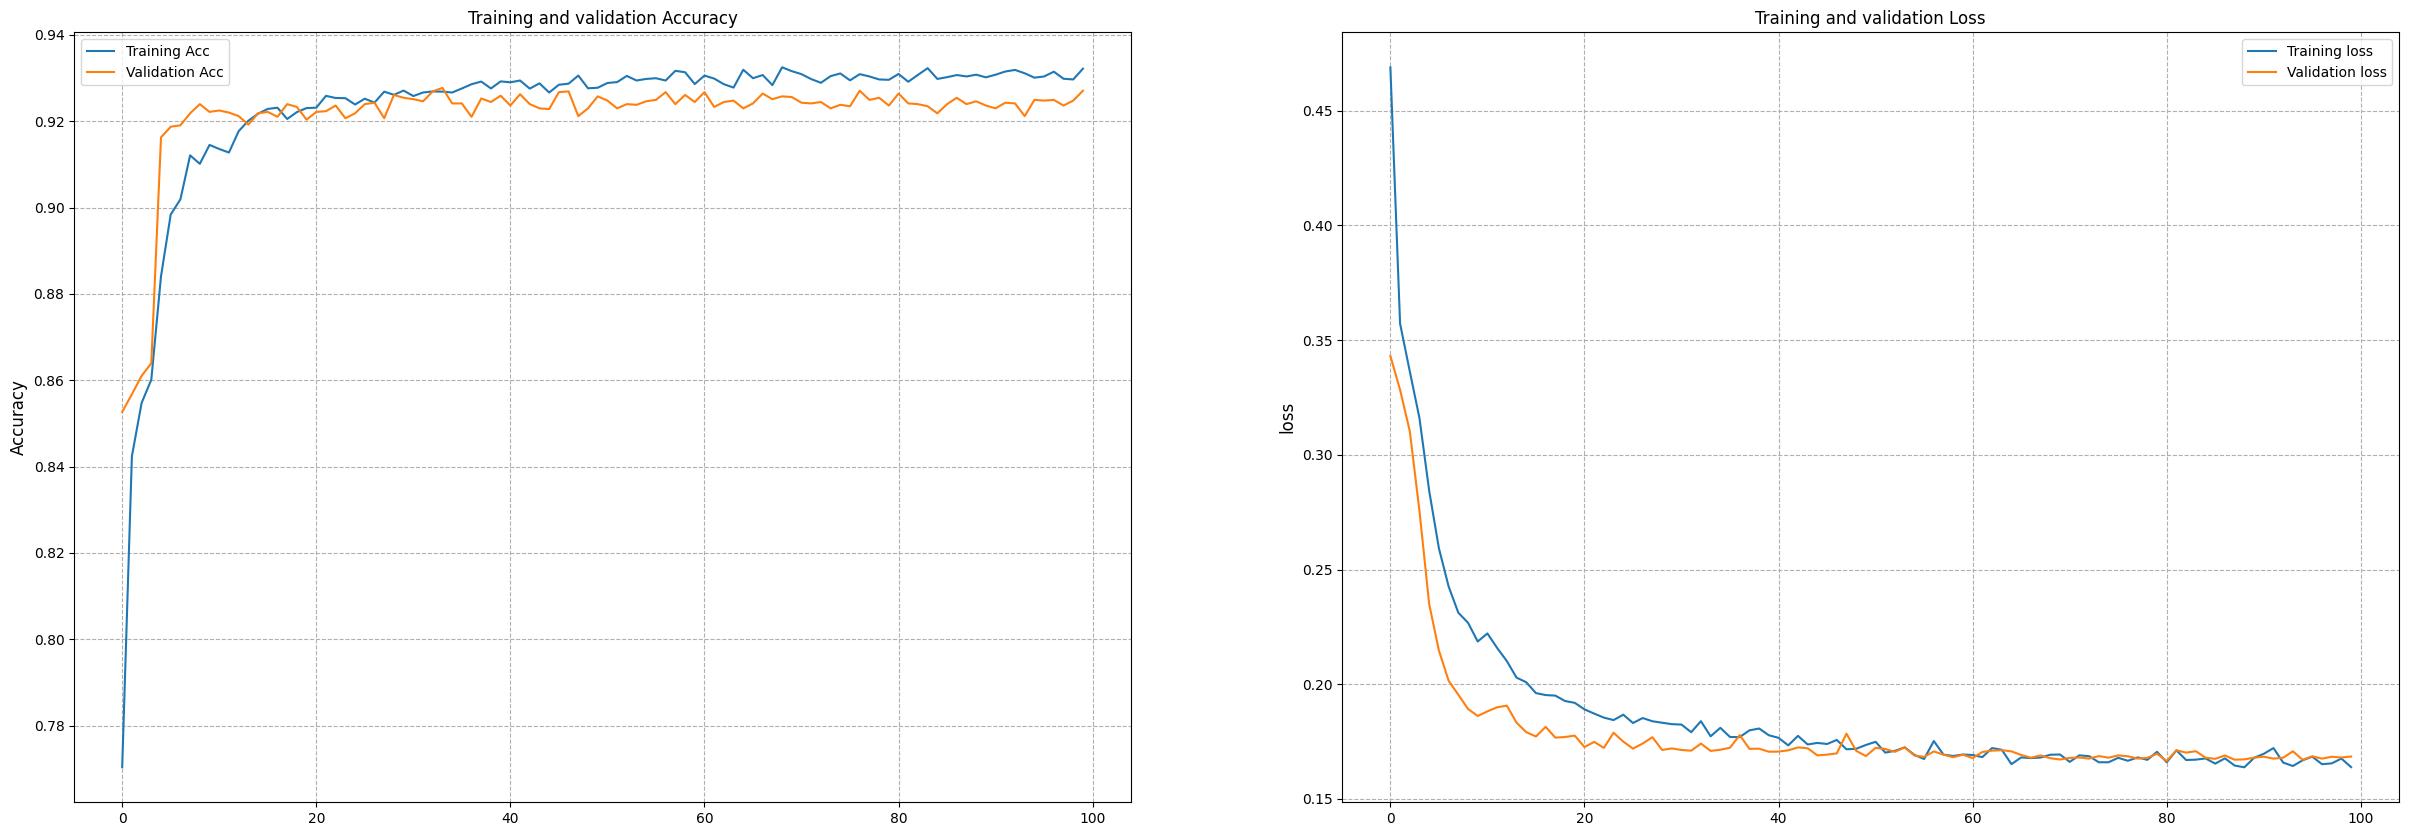

In [101]:
fig,ax= plt.subplots(1,2 , figsize=(30,10))

plt.subplot(1,2,1)
plt.title('Training and validation Accuracy', fontsize=12)
plt.plot(history_func_tuned.history['accuracy'], label='Training Acc')
plt.plot(history_func_tuned.history['val_accuracy'], label='Validation Acc')
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(linestyle='--')

plt.subplot(1,2,2)
plt.title('Training and validation Loss', fontsize=12)
plt.plot(history_func_tuned.history['loss'], label='Training loss')
plt.plot(history_func_tuned.history['val_loss'], label='Validation loss')
plt.ylabel('loss', fontsize=12)
plt.legend()
plt.grid(linestyle='--')
plt.show()

In [102]:
#print accuracy and loss on train and test
print('Train Accuracy: ', model_func_tuned.evaluate(train_tr, y_train)[1])
print('Test Accuracy: ', model_func_tuned.evaluate(test_tr, y_test)[1])

765/765 [==============================] - 0s 372us/step - loss: 0.1512 - accuracy: 0.9365
Train Accuracy:  0.9365416765213013
107/107 [==============================] - 0s 393us/step - loss: 0.1521 - accuracy: 0.9379
Test Accuracy:  0.9378863573074341


In [103]:
#predict
y_pred_train = model_func_tuned.predict(train_tr)
y_pred_test = model_func_tuned.predict(test_tr)

y_pred_train = np.where(y_pred_train > 0.5, 1, 0)
y_pred_test = np.where(y_pred_test > 0.5, 1, 0)

107/107 [==============================] - 0s 318us/step


In [104]:
print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94     12225
           1       0.96      0.92      0.94     12232

    accuracy                           0.94     24457
   macro avg       0.94      0.94      0.94     24457
weighted avg       0.94      0.94      0.94     24457

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1698
           1       0.96      0.92      0.94      1699

    accuracy                           0.94      3397
   macro avg       0.94      0.94      0.94      3397
weighted avg       0.94      0.94      0.94      3397



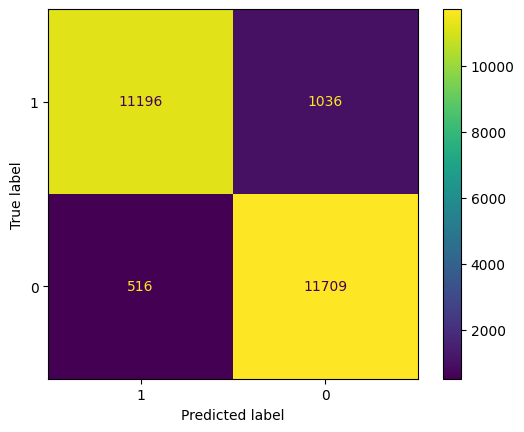

In [105]:
#confusion matrix train
cm = confusion_matrix(y_train, y_pred_train, labels=[1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,0])
disp.plot()

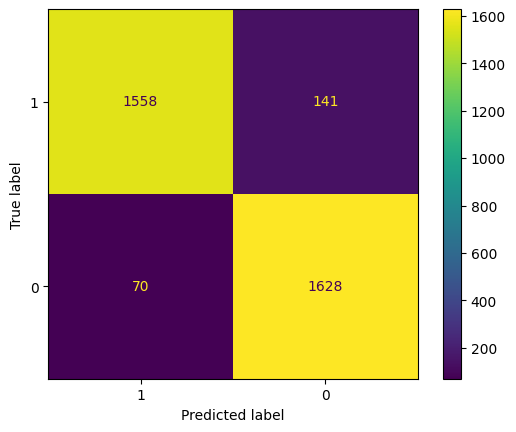

In [106]:
#confusion matrix test
cm = confusion_matrix(y_test, y_pred_test, labels=[1,0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,0])
disp.plot()

The model has been improvised, marked by the val accuracy value which is close to the accuracy value in the graph above.

**Best Model:** The model that uses functinonal api and has been tuned is better because of its higher accuracy value of 0.94 (classification_report). This model is also seen from the graph, has a graph that can indicate the model is not overfitting.

# Save

In [113]:
joblib.dump(preprocessor, open('preprocess.pkl', 'wb'))
model_func.save('ann_wq5.h5')

/Users/wahyupermana/miniforge3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
